In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("csv")
EXPECTED_COLS = ["Lp","Numer rejestracyjny","Wnioskodawca","Tytuł projektu","Kwota",
                 "Data przyznania","Konkurs","Moduł"]

csv_files = sorted({f.resolve().as_posix().lower(): f for f in DATA_DIR.glob("*.csv")}.values(),
                   key=lambda p: p.name)
print(f"Found {len(csv_files)} CSV files:")
for f in csv_files: print(" -", f.name)


Found 9 CSV files:
 - 20200507 I konkurs I Biblioteki_cleaned.csv
 - 20200507 I konkurs I Popularyzacja_cleaned.csv
 - 20211231 I konkurs II Biblioteki_cleaned.csv
 - 20211231 I konkurs II Popularyzacja_cleaned.csv
 - 20220926 I konkurs III Biblioteki_cleaned.csv
 - 20220926 I konkurs III Popularyzacja_cleaned.csv
 - 20241104 II Biblioteki_cleaned.csv
 - 20241104 II Popularyzacja_cleaned.csv
 - 20241230 II Popularyzacja - lista dodatkowa_cleaned.csv


In [3]:
dfs = []
for file in csv_files:
    df = pd.read_csv(file, dtype=str)
    df.columns = df.columns.str.strip().str.replace(r"[\u200b\u200e\u200f\uFEFF]", "", regex=True)
    for col in EXPECTED_COLS:
        if col not in df.columns:
            df[col] = pd.NA
    df = df[EXPECTED_COLS].copy()
    df["Źródło"] = file.stem
    dfs.append(df)

if not dfs:
    raise ValueError("Brak plików do wczytania (sprawdź DATA_DIR).")

df_all = pd.concat(dfs, ignore_index=True)

kwota_series = (
    df_all["Kwota"].astype(str)
    .str.replace(r"[^\d,.\-]", "", regex=True)
    .str.replace(r"\.(?=\d{3}(?:\D|$))", "", regex=True)
    .str.replace(",", ".", regex=False)
)
df_all["Kwota_clean"] = pd.to_numeric(kwota_series, errors="coerce")
df_all["Rok"] = pd.to_datetime(df_all["Data przyznania"], errors="coerce").dt.year

print(f"\nMerged {len(df_all)} rows in total.")
print("Columns:", df_all.columns.tolist())
display(df_all.head(10))



Merged 830 rows in total.
Columns: ['Lp', 'Numer rejestracyjny', 'Wnioskodawca', 'Tytuł projektu', 'Kwota', 'Data przyznania', 'Konkurs', 'Moduł', 'Źródło', 'Kwota_clean', 'Rok']


,Lp,Numer rejestracyjny,Wnioskodawca,Tytuł projektu,Kwota,Data przyznania,Konkurs,Moduł,Źródło,Kwota_clean,Rok
0,1,SONB/SP/461244/2020,Akademia Muzyczna im. Karola Szymanowskiego w ...,Budowa cyfrowego repozytorium kolekcji afiszy ...,223344,2020-05-07,SON I konkurs I,Biblioteki,20200507 I konkurs I Biblioteki_cleaned,223344.0,2020
1,2,SONB/SN/469058/2020,Diecezja Sandomierska,"Konserwacja zachowawcza,opracowanie i udostępn...",250000,2020-05-07,SON I konkurs I,Biblioteki,20200507 I konkurs I Biblioteki_cleaned,250000.0,2020
2,3,SONB/SN/469156/2020,Diecezja Sandomierska,"Konserwacja, opracowanie i udostępnienie 70 st...",224734,2020-05-07,SON I konkurs I,Biblioteki,20200507 I konkurs I Biblioteki_cleaned,224734.0,2020
3,4,SONB/SP/461397/2020,Katolicki Uniwersytet Lubelski Jana Pawła II,Opracowanie i digitalizacja dawnych unikatowyc...,170280,2020-05-07,SON I konkurs I,Biblioteki,20200507 I konkurs I Biblioteki_cleaned,170280.0,2020
4,5,SONB/SP/461400/2020,Katolicki Uniwersytet Lubelski Jana Pawła II,Digitalizacja unikatowych periodyków ukraiński...,218460,2020-05-07,SON I konkurs I,Biblioteki,20200507 I konkurs I Biblioteki_cleaned,218460.0,2020
5,6,SONB/SN/468945/2020,Papieski Wydział Teologiczny w Warszawie,Unikatowe zbiory muzyki polskiej w Bibliotece ...,198000,2020-05-07,SON I konkurs I,Biblioteki,20200507 I konkurs I Biblioteki_cleaned,198000.0,2020
6,7,SONB/SP/462133/2020,Politechnika Gdańska,"Konserwacja, digitalizacja i udostępnienie 15 ...",121000,2020-05-07,SON I konkurs I,Biblioteki,20200507 I konkurs I Biblioteki_cleaned,121000.0,2020
7,8,SONB/SP/461242/2020,Politechnika Warszawska,Upowszechnianie kolekcji fotografii dokumentuj...,73124,2020-05-07,SON I konkurs I,Biblioteki,20200507 I konkurs I Biblioteki_cleaned,73124.0,2020
8,9,SONB/SP/465811/2020,Politechnika Warszawska,"Opracowanie, digitalizacja oraz upowszechnieni...",146175,2020-05-07,SON I konkurs I,Biblioteki,20200507 I konkurs I Biblioteki_cleaned,146175.0,2020
9,10,SONB/SP/463076/2020,Politechnika Wrocławska,Digitalizacja pomiarów architektonicznych oraz...,114330,2020-05-07,SON I konkurs I,Biblioteki,20200507 I konkurs I Biblioteki_cleaned,114330.0,2020


In [4]:
df_all["Kwota_clean"] = (
    df_all["Kwota"]
    .astype(str)
    .str.replace(r"[^\d,\.]", "", regex=True)
    .str.replace(",", ".", regex=False)
    .str.replace(r"\.(?=\d{3}\b)", "", regex=True)  # usuń separator tysiąca
)

df_all["Kwota_clean"] = pd.to_numeric(df_all["Kwota_clean"], errors="coerce")

print("Zakres kwot (PLN):")
print(df_all["Kwota_clean"].describe())


Zakres kwot (PLN):
count        830.000000
mean      207355.717373
std       205265.362217
min        20000.000000
25%        77551.250000
50%       136275.000000
75%       247940.000000
max      1000000.000000
Name: Kwota_clean, dtype: float64


In [5]:
df_all["Rok"] = pd.to_datetime(df_all["Data przyznania"], errors="coerce").dt.year

df_all[["Data przyznania", "Rok", "Konkurs", "Moduł"]].head()


,Data przyznania,Rok,Konkurs,Moduł
0,2020-05-07,2020,SON I konkurs I,Biblioteki
1,2020-05-07,2020,SON I konkurs I,Biblioteki
2,2020-05-07,2020,SON I konkurs I,Biblioteki
3,2020-05-07,2020,SON I konkurs I,Biblioteki
4,2020-05-07,2020,SON I konkurs I,Biblioteki


In [6]:
df_sum = (
    df_all.groupby(["Rok", "Moduł"], dropna=False)["Kwota_clean"]
    .sum()
    .reset_index()
    .sort_values(["Rok", "Moduł"])
)

print("Suma przyznanych kwot (PLN):")
display(df_sum)


Suma przyznanych kwot (PLN):


,Rok,Moduł,Kwota_clean
0,2020,Biblioteki,4744994.01
1,2020,Popularyzacja,38455301.07
2,2021,Biblioteki,4993559.33
3,2021,Popularyzacja,46372191.96
4,2022,Biblioteki,5085284.13
5,2022,Popularyzacja,42251936.35
6,2024,Biblioteki,8880583.20
7,2024,Popularyzacja,21321395.37


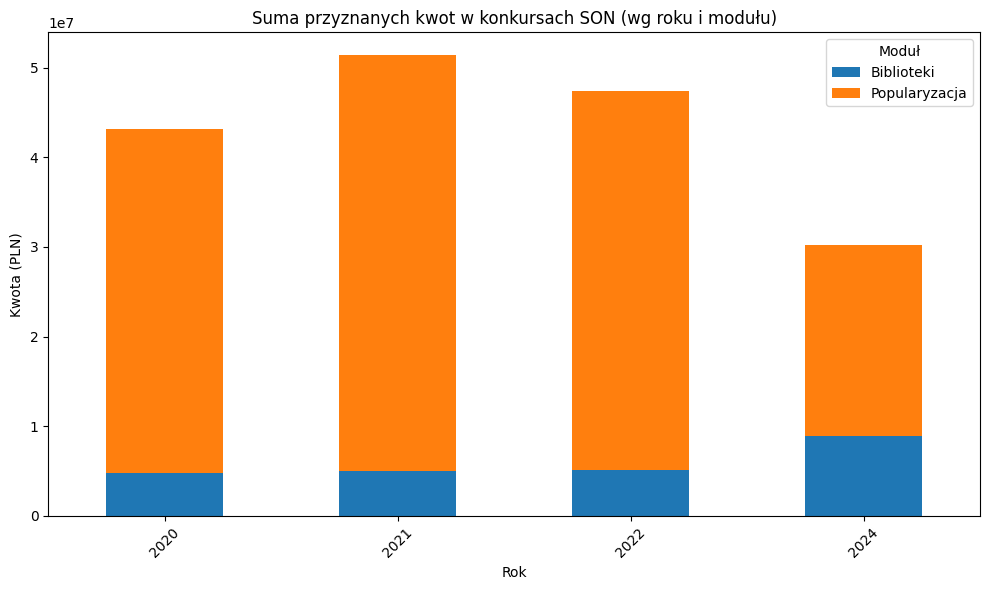

In [7]:
import matplotlib.pyplot as plt

df_pivot = df_sum.pivot(index="Rok", columns="Moduł", values="Kwota_clean")

df_pivot.plot(
    kind="bar",
    stacked=True,
    figsize=(10,6)
)

plt.title("Suma przyznanych kwot w konkursach SON (wg roku i modułu)")
plt.xlabel("Rok")
plt.ylabel("Kwota (PLN)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


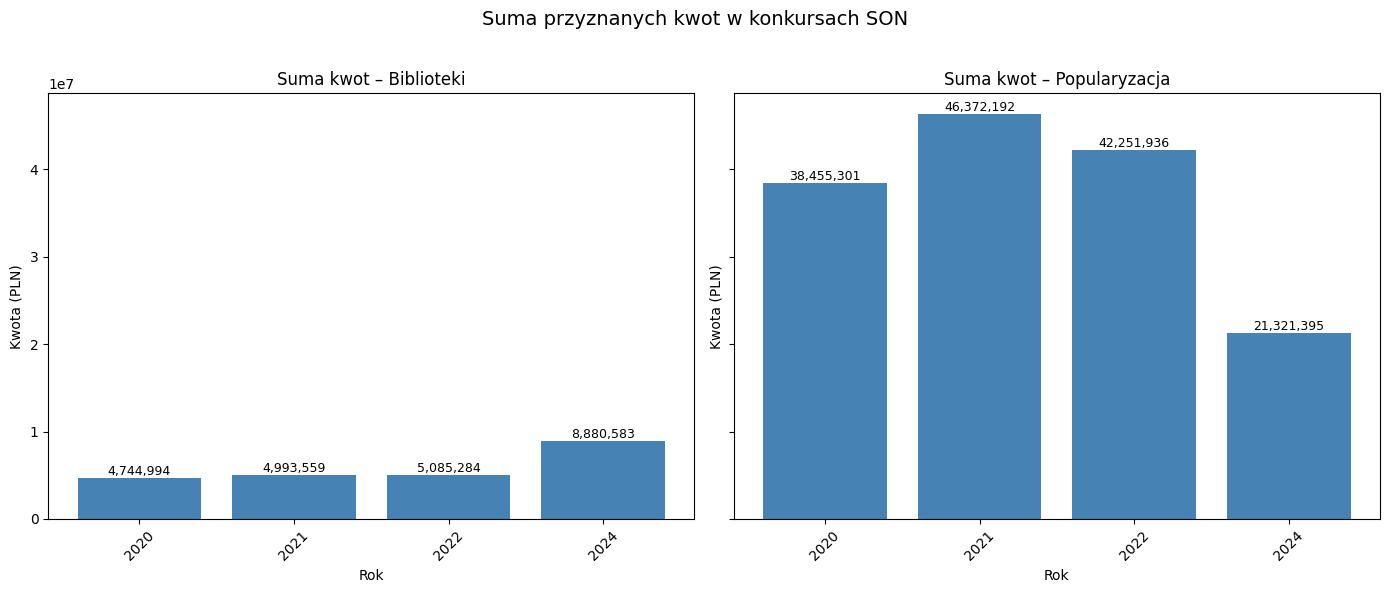

In [8]:
import matplotlib.pyplot as plt

if "df_sum" not in locals():
    raise NameError("Najpierw uruchom komórki 4–6, by utworzyć df_sum")

moduly = df_sum["Moduł"].unique()

fig, axes = plt.subplots(1, len(moduly), figsize=(14, 6), sharey=True)

if len(moduly) == 1:
    axes = [axes]

for ax, modul in zip(axes, moduly):
    sub = df_sum[df_sum["Moduł"] == modul]
    ax.bar(sub["Rok"].astype(str), sub["Kwota_clean"], color="steelblue")
    ax.set_title(f"Suma kwot – {modul}")
    ax.set_xlabel("Rok")
    ax.set_ylabel("Kwota (PLN)")
    ax.tick_params(axis="x", rotation=45)
    for i, val in enumerate(sub["Kwota_clean"]):
        ax.text(i, val, f"{val:,.0f}", ha="center", va="bottom", fontsize=9)

plt.suptitle("Suma przyznanych kwot w konkursach SON", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
df = df_all.copy()

top_counts = (
    df["Wnioskodawca"]
    .value_counts()
    .head(10)
    .reset_index()
    .rename(columns={"index":"Wnioskodawca","Wnioskodawca":"Liczba projektów"})
)

top_amounts = (
    df.groupby("Wnioskodawca", dropna=False)["Kwota_clean"]
    .sum()
    .nlargest(10)
    .reset_index()
    .rename(columns={"Kwota_clean":"Suma kwot"})
)

display(top_counts)
display(top_amounts)


,Liczba projektów,count
0,Uniwersytet Łódzki,17
1,Uniwersytet Warszawski,16
2,Uniwersytet Wrocławski,13
3,Uniwersytet Jana Kochanowskiego w Kielcach,13
4,Uniwersytet w Białymstoku,12
5,Uniwersytet Jagielloński,12
6,Uniwersytet im. Adama Mickiewicza w Poznaniu,12
7,Katolicki Uniwersytet Lubelski Jana Pawła II,11
8,Politechnika Śląska,10
9,Uniwersytet Ekonomiczny w Poznaniu,10


,Wnioskodawca,Suma kwot
0,Katolicki Uniwersytet Lubelski Jana Pawła II,3690691.60
1,Politechnika Lubelska,3414492.09
2,Uniwersytet Śląski w Katowicach,3022263.31
3,Uniwersytet im. Adama Mickiewicza w Poznaniu,2825923.68
4,Stowarzyszenie Rzecznicy Nauki,2793809.00
5,Fundacja Nicolaus Copernicus,2675000.00
6,Śląski Uniwersytet Medyczny w Katowicach,2643898.90
7,Fundacja Centrum Kopernika,2541964.37
8,Uniwersytet Warszawski,2505178.50
9,Politechnika Świętokrzyska,2433797.50


In [10]:
df = df_all.copy()

top_counts = (
    df["Wnioskodawca"]
    .value_counts()
    .head(10)
    .reset_index()
)
top_counts.columns = ["Wnioskodawca", "Liczba projektów"]


top_amounts = (
    df.groupby("Wnioskodawca", dropna=False)["Kwota_clean"]
    .sum()
    .nlargest(10)
    .reset_index()
)
top_amounts.columns = ["Wnioskodawca", "Suma kwot"]


print("--- Top 10 wg liczby projektów ---")
display(top_counts)
print("\n--- Top 10 wg sumy finansowania ---")
display(top_amounts)

--- Top 10 wg liczby projektów ---


,Wnioskodawca,Liczba projektów
0,Uniwersytet Łódzki,17
1,Uniwersytet Warszawski,16
2,Uniwersytet Wrocławski,13
3,Uniwersytet Jana Kochanowskiego w Kielcach,13
4,Uniwersytet w Białymstoku,12
5,Uniwersytet Jagielloński,12
6,Uniwersytet im. Adama Mickiewicza w Poznaniu,12
7,Katolicki Uniwersytet Lubelski Jana Pawła II,11
8,Politechnika Śląska,10
9,Uniwersytet Ekonomiczny w Poznaniu,10



--- Top 10 wg sumy finansowania ---


,Wnioskodawca,Suma kwot
0,Katolicki Uniwersytet Lubelski Jana Pawła II,3690691.60
1,Politechnika Lubelska,3414492.09
2,Uniwersytet Śląski w Katowicach,3022263.31
3,Uniwersytet im. Adama Mickiewicza w Poznaniu,2825923.68
4,Stowarzyszenie Rzecznicy Nauki,2793809.00
5,Fundacja Nicolaus Copernicus,2675000.00
6,Śląski Uniwersytet Medyczny w Katowicach,2643898.90
7,Fundacja Centrum Kopernika,2541964.37
8,Uniwersytet Warszawski,2505178.50
9,Politechnika Świętokrzyska,2433797.50


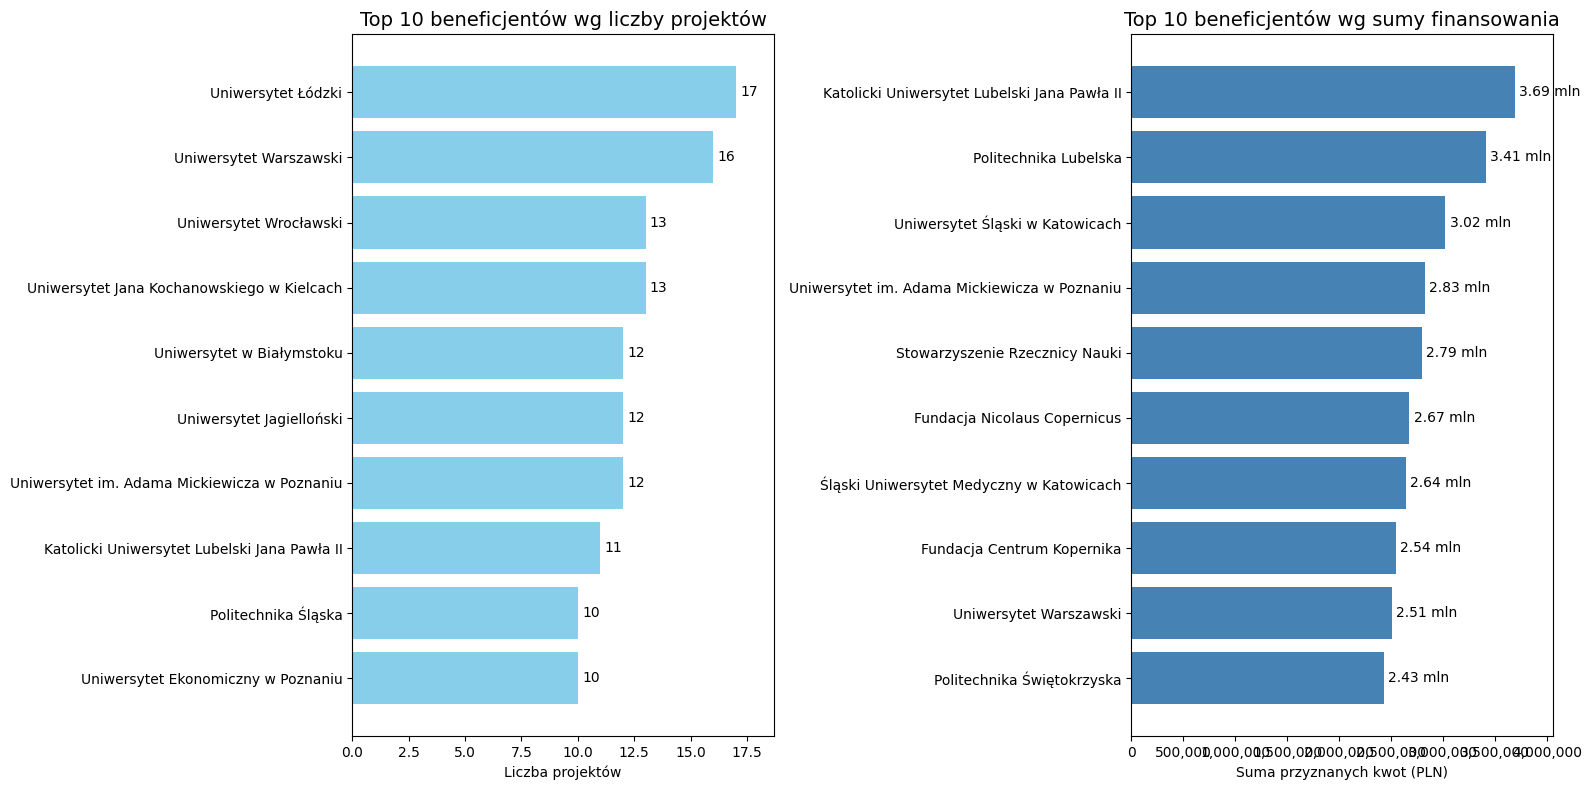

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.barh(top_counts["Wnioskodawca"], top_counts["Liczba projektów"], color='skyblue')
ax1.set_title("Top 10 beneficjentów wg liczby projektów", fontsize=14)
ax1.set_xlabel("Liczba projektów")
ax1.invert_yaxis()
ax1.bar_label(ax1.containers[0], padding=3)
ax1.set_xlim(right=top_counts["Liczba projektów"].max() * 1.1)

bars = ax2.barh(top_amounts["Wnioskodawca"], top_amounts["Suma kwot"], color='steelblue')
ax2.set_title("Top 10 beneficjentów wg sumy finansowania", fontsize=14)
ax2.set_xlabel("Suma przyznanych kwot (PLN)")
ax2.invert_yaxis()
ax2.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax2.bar_label(
    ax2.containers[0],
    labels=[f'{x/1_000_000:.2f} mln' for x in top_amounts["Suma kwot"]],
    padding=3
)
ax2.set_xlim(right=top_amounts["Suma kwot"].max() * 1.1) # Dodaj miejsce na etykiety


plt.tight_layout()
plt.show()

In [12]:
df_amounts_details = df[df['Wnioskodawca'].isin(top_amounts['Wnioskodawca'])].copy()

df_amounts_grouped = df_amounts_details.groupby(['Wnioskodawca', 'Konkurs', 'Moduł'])['Kwota_clean'].sum().reset_index()

df_amounts_pivot = df_amounts_grouped.pivot_table(
    index='Wnioskodawca',
    columns=['Konkurs', 'Moduł'],
    values='Kwota_clean'
).fillna(0)

df_amounts_pivot = df_amounts_pivot.reindex(top_amounts['Wnioskodawca'])

df_counts_details = df[df['Wnioskodawca'].isin(top_counts['Wnioskodawca'])].copy()

df_counts_grouped = df_counts_details.groupby(['Wnioskodawca', 'Konkurs', 'Moduł']).size().reset_index(name='Liczba projektów')

df_counts_pivot = df_counts_grouped.pivot_table(
    index='Wnioskodawca',
    columns=['Konkurs', 'Moduł'],
    values='Liczba projektów'
).fillna(0)

df_counts_pivot = df_counts_pivot.reindex(top_counts['Wnioskodawca'])

print("Struktura danych dla wykresu wg sumy kwot:")
display(df_amounts_pivot.head())

Struktura danych dla wykresu wg sumy kwot:


Konkurs                                      SON I konkurs I                \
Moduł                                             Biblioteki Popularyzacja   
Wnioskodawca                                                                 
Katolicki Uniwersytet Lubelski Jana Pawła II        388740.0     361240.00   
Politechnika Lubelska                                    0.0          0.00   
Uniwersytet Śląski w Katowicach                      53756.5    1942650.65   
Uniwersytet im. Adama Mickiewicza w Poznaniu             0.0     677110.00   
Stowarzyszenie Rzecznicy Nauki                           0.0     915375.00   

Konkurs                                      SON I konkurs II                \
Moduł                                              Biblioteki Popularyzacja   
Wnioskodawca                                                                  
Katolicki Uniwersytet Lubelski Jana Pawła II         244329.0     1805682.6   
Politechnika Lubelska                                     0.0      400000.0   
Uniwersytet Śląski w Katowicach                      203057.0      200000.0   
Uniwersytet im. Adama Mickiewicza w Poznaniu              0.0           0.0   
Stowarzyszenie Rzecznicy Nauki                            0.0      978434.0   

Konkurs                                      SON I konkurs III                \
Moduł                                               Biblioteki Popularyzacja   
Wnioskodawca                                                                   
Katolicki Uniwersytet Lubelski Jana Pawła II              0.00     890700.00   
Politechnika Lubelska                                136189.55    1907277.54   
Uniwersytet Śląski w Katowicach                           0.00     377701.50   
Uniwersytet im. Adama Mickiewicza w Poznaniu         223044.80    1178958.00   
Stowarzyszenie Rzecznicy Nauki                            0.00     900000.00   

Konkurs                                          SON II                
Moduł                                        Biblioteki Popularyzacja  
Wnioskodawca                                                           
Katolicki Uniwersytet Lubelski Jana Pawła II       0.00           0.0  
Politechnika Lubelska                              0.00      971025.0  
Uniwersytet Śląski w Katowicach               245097.66           0.0  
Uniwersytet im. Adama Mickiewicza w Poznaniu  470820.88      275990.0  
Stowarzyszenie Rzecznicy Nauki                     0.00           0.0

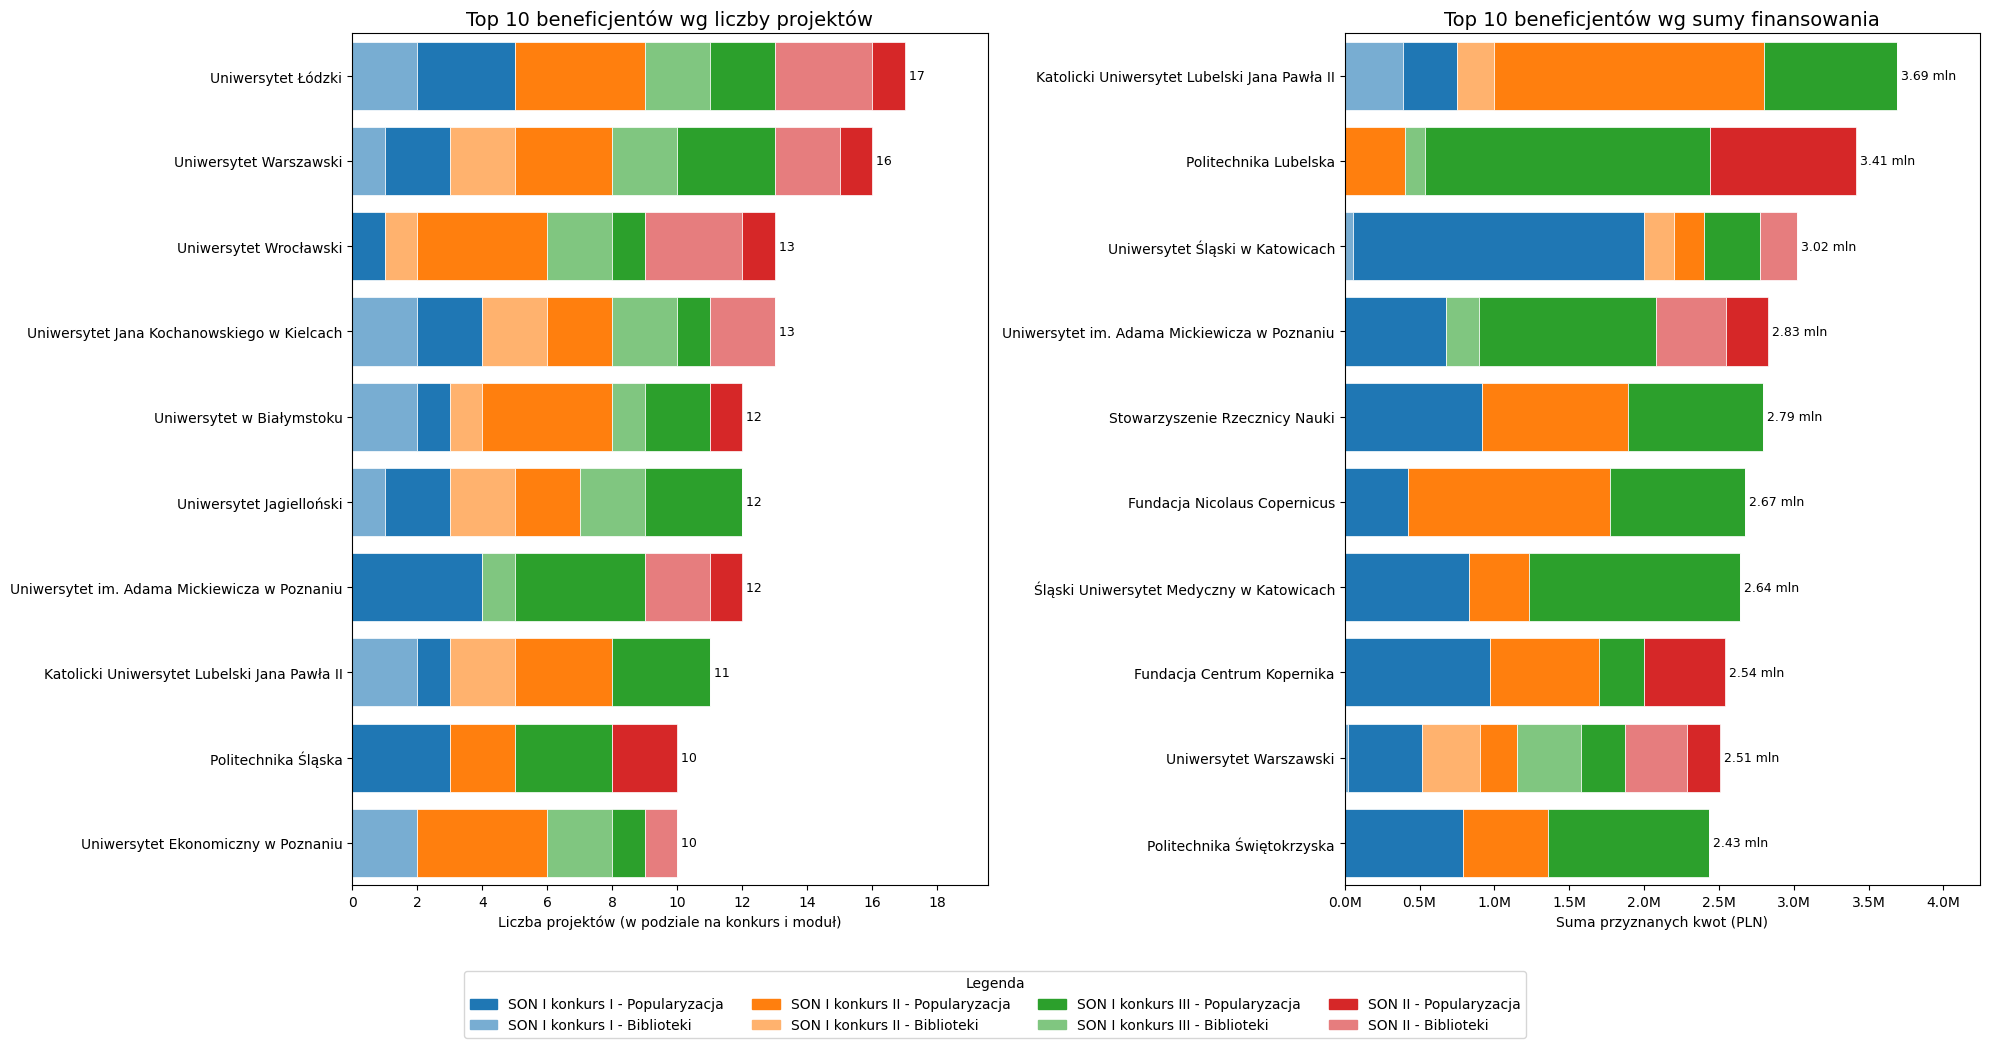

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy as np

konkurs_colors = {
    'SON I konkurs I': '#1f77b4',
    'SON I konkurs II': '#ff7f0e',
    'SON I konkurs III': '#2ca02c',
    'SON II': '#d62728',
}

modul_shades = {
    'Popularyzacja': 1.0,
    'Biblioteki': 0.6,
}

def adjust_hex_brightness(hex_color, factor):
    if factor == 1.0:
        return hex_color
    rgb = [int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)]
    adjusted_rgb = [min(255, int(c * factor + (255 * (1-factor)))) for c in rgb]
    return f"#{''.join([f'{c:02x}' for c in adjusted_rgb])}"

def create_stacked_barh_chart(ax, pivot_df, title_text, xlabel_text, is_amount):
    """
    Tworzy zaawansowany, skumulowany wykres słupkowy poziomy.
    ax: Oś Matplotlib, na której rysowany jest wykres.
    pivot_df: Tabela przestawna z danymi.
    title_text: Tytuł wykresu.
    xlabel_text: Etykieta osi X.
    is_amount: Boolean, czy dane to kwoty (do formatowania etykiet).
    """
    beneficjenci = pivot_df.index
    left_positions = np.zeros(len(beneficjenci))
    
    sorted_columns = sorted(pivot_df.columns, key=lambda x: (x[0], x[1]))

    for konkurs, modul in sorted_columns:
        values = pivot_df[(konkurs, modul)]
        
        base_color = konkurs_colors.get(konkurs, '#888888')
        shade_factor = modul_shades.get(modul, 1.0)
        color = adjust_hex_brightness(base_color, shade_factor)

        bars = ax.barh(beneficjenci, values, left=left_positions, color=color, edgecolor='white', linewidth=0.5)
        
        left_positions += values.values

    ax.set_title(title_text, fontsize=14)
    ax.set_xlabel(xlabel_text)
    ax.invert_yaxis()
    ax.margins(y=0.01)

    if is_amount:
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x/1_000_000:.1f}M'))
        totals = pivot_df.sum(axis=1)
        for i, total in enumerate(totals):
            ax.text(total, i, f' {total/1_000_000:.2f} mln', va='center', ha='left', fontsize=9)
        ax.set_xlim(right=totals.max() * 1.15)
    else:
        totals = pivot_df.sum(axis=1)
        for i, total in enumerate(totals):
            ax.text(total, i, f' {int(total)}', va='center', ha='left', fontsize=9)
        ax.set_xlim(right=totals.max() * 1.15)
        ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

create_stacked_barh_chart(ax1, df_counts_pivot, 
                          "Top 10 beneficjentów wg liczby projektów", 
                          "Liczba projektów (w podziale na konkurs i moduł)", 
                          is_amount=False)

create_stacked_barh_chart(ax2, df_amounts_pivot, 
                          "Top 10 beneficjentów wg sumy finansowania", 
                          "Suma przyznanych kwot (PLN)", 
                          is_amount=True)

legend_patches = []
all_combinations = sorted(set(df_counts_pivot.columns) | set(df_amounts_pivot.columns))

for konkurs in sorted(konkurs_colors.keys()):
    for modul, shade in modul_shades.items():
        if any(c[0] == konkurs and c[1] == modul for c in all_combinations):
             base_color = konkurs_colors.get(konkurs)
             color = adjust_hex_brightness(base_color, shade)
             label = f"{konkurs} - {modul}"
             legend_patches.append(mpatches.Patch(color=color, label=label))

fig.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, 0.03), ncol=4, title="Legenda")

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

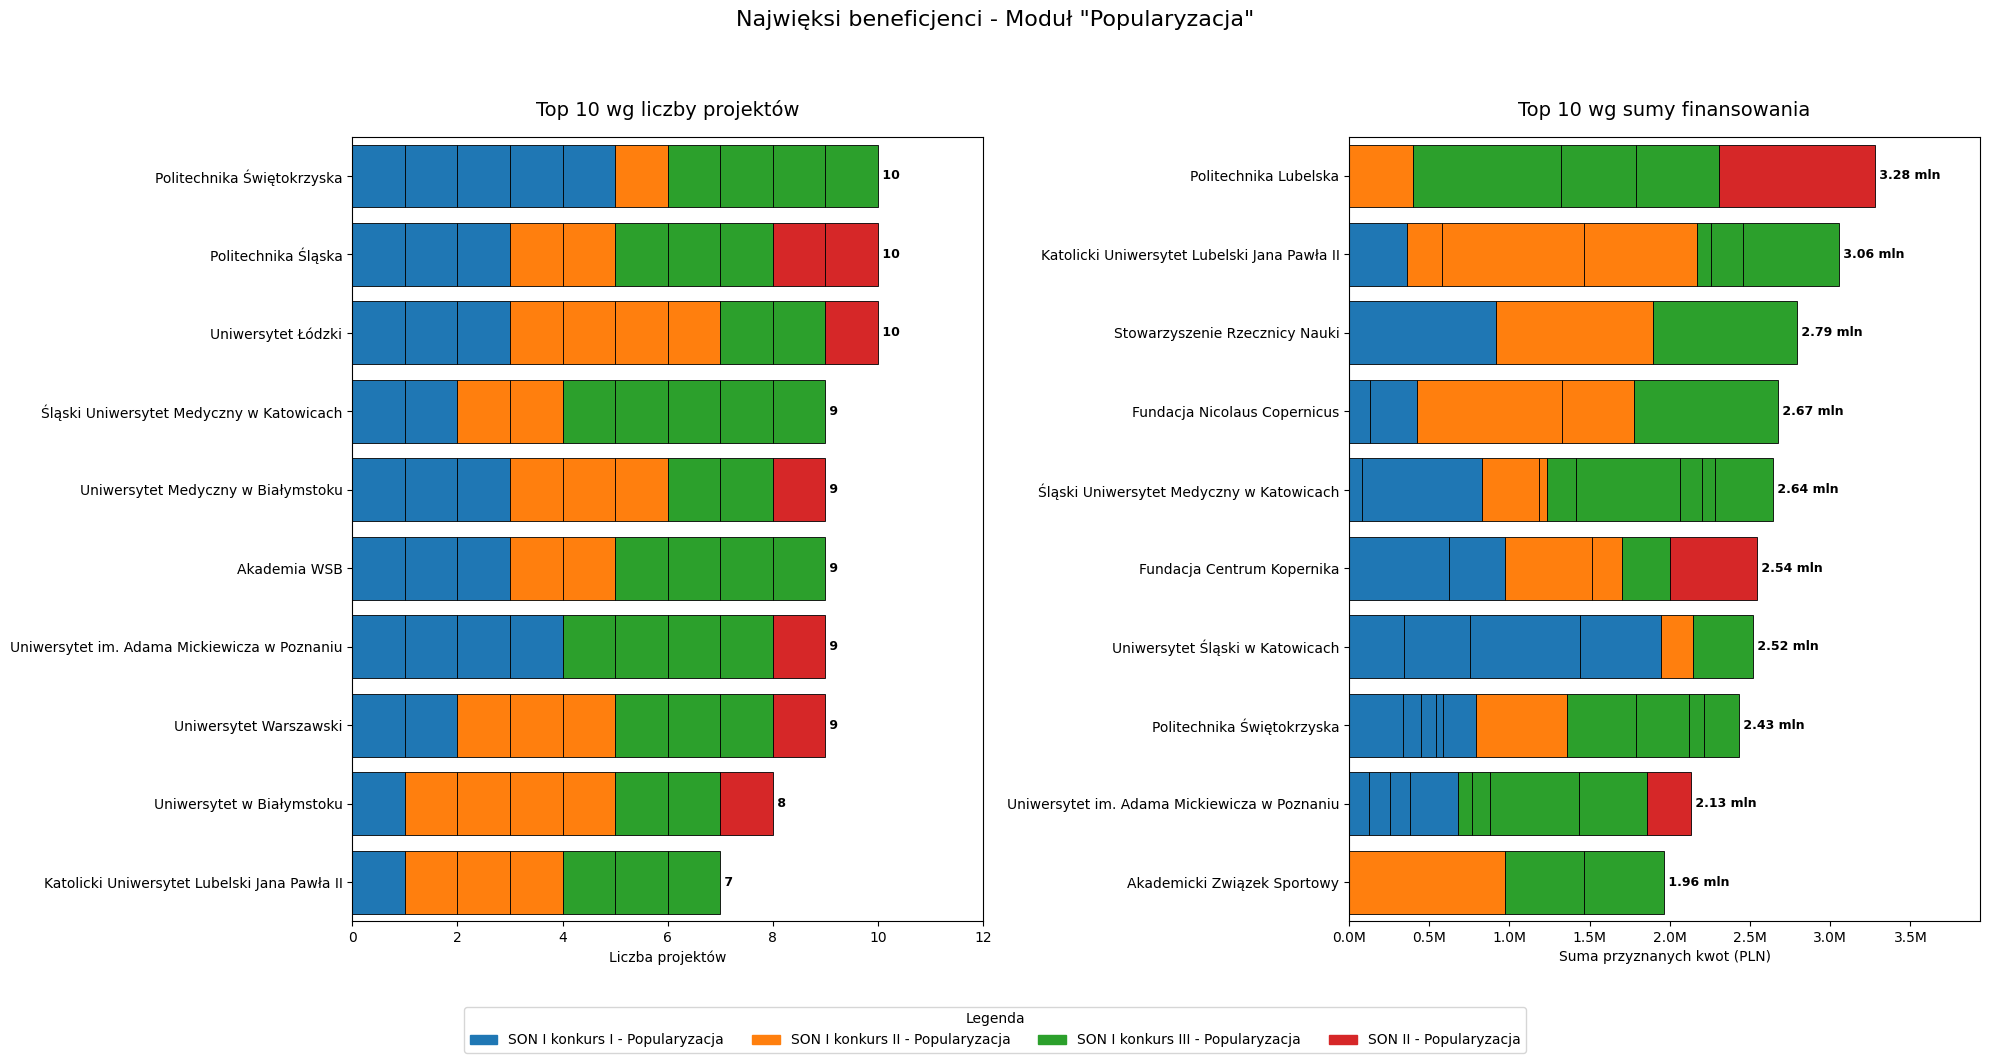

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy as np

konkurs_colors = {
    'SON I konkurs I': '#1f77b4',
    'SON I konkurs II': '#ff7f0e',
    'SON I konkurs III': '#2ca02c',
    'SON II': '#d62728',
}
modul_shades = {
    'Popularyzacja': 1.0,
    'Biblioteki': 0.6,
}
def adjust_hex_brightness(hex_color, factor):
    if factor == 1.0: return hex_color
    rgb = [int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)]
    adjusted_rgb = [min(255, int(c * factor + (255 * (1-factor)))) for c in rgb]
    return f"#{''.join([f'{c:02x}' for c in adjusted_rgb])}"

def create_detailed_stacked_barh_chart(ax, long_df, value_col, title_text, xlabel_text, is_amount):
    beneficjenci = long_df['Wnioskodawca'].cat.categories
    left_positions = {b: 0 for b in beneficjenci}
    for index, row in long_df.iterrows():
        beneficjent, konkurs, modul, value = row['Wnioskodawca'], row['Konkurs'], row['Moduł'], row[value_col]
        base_color = konkurs_colors.get(konkurs, '#888888')
        shade_factor = modul_shades.get(modul, 1.0)
        color = adjust_hex_brightness(base_color, shade_factor)
        left = left_positions[beneficjent]
        ax.barh(beneficjent, value, left=left, color=color, edgecolor='black', linewidth=0.6, align='center')
        left_positions[beneficjent] += value
    ax.set_title(title_text, fontsize=14, pad=15)
    ax.set_xlabel(xlabel_text)
    ax.invert_yaxis()
    ax.margins(y=0.01)
    totals = long_df.groupby('Wnioskodawca', observed=True)[value_col].sum()
    if is_amount:
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x/1_000_000:.1f}M'))
        for i, total in enumerate(totals): ax.text(total, i, f' {total/1_000_000:.2f} mln', va='center', ha='left', fontsize=9, weight='bold')
        ax.set_xlim(right=totals.max() * 1.20)
    else:
        for i, total in enumerate(totals): ax.text(total, i, f' {int(total)}', va='center', ha='left', fontsize=9, weight='bold')
        ax.set_xlim(right=totals.max() * 1.20)
        ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))


df_pop = df_all[df_all['Moduł'] == 'Popularyzacja'].copy()

top_counts_pop = df_pop['Wnioskodawca'].value_counts().head(10).reset_index()
top_counts_pop.columns = ["Wnioskodawca", "Liczba projektów"]

top_amounts_pop = df_pop.groupby("Wnioskodawca")['Kwota_clean'].sum().nlargest(10).reset_index()
top_amounts_pop.columns = ["Wnioskodawca", "Suma kwot"]

df_counts_long_pop = df_pop[df_pop['Wnioskodawca'].isin(top_counts_pop['Wnioskodawca'])].copy()
df_counts_long_pop['Liczba projektów'] = 1
df_counts_long_pop['Wnioskodawca'] = pd.Categorical(df_counts_long_pop['Wnioskodawca'], categories=top_counts_pop['Wnioskodawca'], ordered=True)
df_counts_long_pop = df_counts_long_pop.sort_values(by=['Wnioskodawca', 'Konkurs', 'Moduł'])

df_amounts_long_pop = df_pop[df_pop['Wnioskodawca'].isin(top_amounts_pop['Wnioskodawca'])].copy()
df_amounts_long_pop['Wnioskodawca'] = pd.Categorical(df_amounts_long_pop['Wnioskodawca'], categories=top_amounts_pop['Wnioskodawca'], ordered=True)
df_amounts_long_pop = df_amounts_long_pop.sort_values(by=['Wnioskodawca', 'Konkurs', 'Moduł'])

fig_pop, (ax1_pop, ax2_pop) = plt.subplots(1, 2, figsize=(20, 10))
fig_pop.suptitle('Najwięksi beneficjenci - Moduł "Popularyzacja"', fontsize=16, y=1.02)

create_detailed_stacked_barh_chart(ax1_pop, df_counts_long_pop, 'Liczba projektów', "Top 10 wg liczby projektów", "Liczba projektów", is_amount=False)
create_detailed_stacked_barh_chart(ax2_pop, df_amounts_long_pop, 'Kwota_clean', "Top 10 wg sumy finansowania", "Suma przyznanych kwot (PLN)", is_amount=True)

legend_patches_pop = []
all_combinations_pop = set(tuple(row) for row in df_pop[['Konkurs', 'Moduł']].drop_duplicates().to_numpy())
for konkurs in sorted(konkurs_colors.keys()):
    for modul, shade in modul_shades.items():
        if (konkurs, modul) in all_combinations_pop:
             base_color = konkurs_colors.get(konkurs)
             color = adjust_hex_brightness(base_color, shade)
             label = f"{konkurs} - {modul}"
             legend_patches_pop.append(mpatches.Patch(color=color, label=label))

fig_pop.legend(handles=legend_patches_pop, loc='upper center', bbox_to_anchor=(0.5, 0.03), ncol=4, title="Legenda")
plt.tight_layout(rect=[0, 0.05, 1, 0.98])
plt.show()

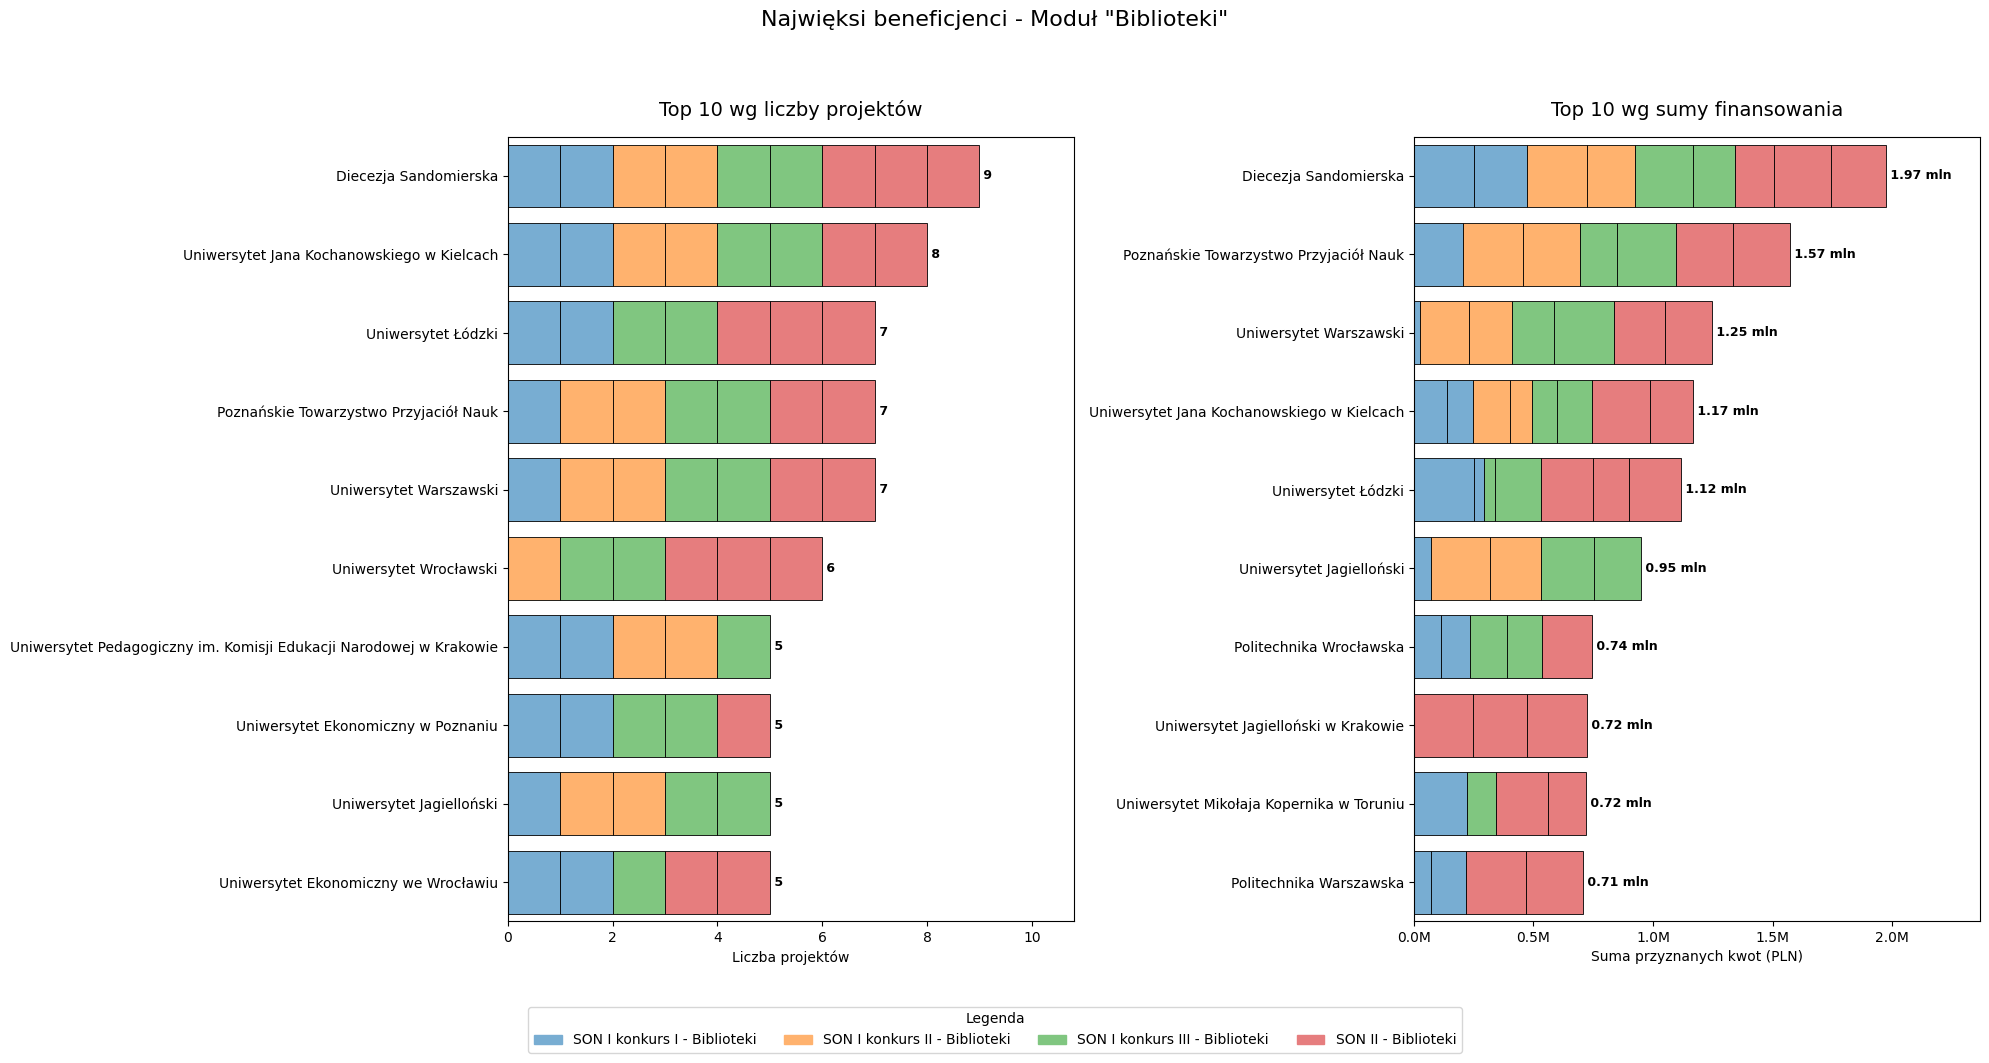

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy as np

konkurs_colors = {
    'SON I konkurs I': '#1f77b4',
    'SON I konkurs II': '#ff7f0e',
    'SON I konkurs III': '#2ca02c',
    'SON II': '#d62728',
}
modul_shades = {
    'Popularyzacja': 1.0,
    'Biblioteki': 0.6,
}
def adjust_hex_brightness(hex_color, factor):
    if factor == 1.0: return hex_color
    rgb = [int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)]
    adjusted_rgb = [min(255, int(c * factor + (255 * (1-factor)))) for c in rgb]
    return f"#{''.join([f'{c:02x}' for c in adjusted_rgb])}"

def create_detailed_stacked_barh_chart(ax, long_df, value_col, title_text, xlabel_text, is_amount):
    beneficjenci = long_df['Wnioskodawca'].cat.categories
    left_positions = {b: 0 for b in beneficjenci}
    for index, row in long_df.iterrows():
        beneficjent, konkurs, modul, value = row['Wnioskodawca'], row['Konkurs'], row['Moduł'], row[value_col]
        base_color = konkurs_colors.get(konkurs, '#888888')
        shade_factor = modul_shades.get(modul, 1.0)
        color = adjust_hex_brightness(base_color, shade_factor)
        left = left_positions[beneficjent]
        ax.barh(beneficjent, value, left=left, color=color, edgecolor='black', linewidth=0.6, align='center')
        left_positions[beneficjent] += value
    ax.set_title(title_text, fontsize=14, pad=15)
    ax.set_xlabel(xlabel_text)
    ax.invert_yaxis()
    ax.margins(y=0.01)
    totals = long_df.groupby('Wnioskodawca', observed=True)[value_col].sum()
    if is_amount:
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x/1_000_000:.1f}M'))
        for i, total in enumerate(totals): ax.text(total, i, f' {total/1_000_000:.2f} mln', va='center', ha='left', fontsize=9, weight='bold')
        ax.set_xlim(right=totals.max() * 1.20)
    else:
        for i, total in enumerate(totals): ax.text(total, i, f' {int(total)}', va='center', ha='left', fontsize=9, weight='bold')
        ax.set_xlim(right=totals.max() * 1.20)
        ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))


df_bibl = df_all[df_all['Moduł'] == 'Biblioteki'].copy()

if df_bibl.empty:
    print("Brak danych dla modułu 'Biblioteki' do wyświetlenia.")
else:
    top_counts_bibl = df_bibl['Wnioskodawca'].value_counts().head(10).reset_index()
    top_counts_bibl.columns = ["Wnioskodawca", "Liczba projektów"]

    top_amounts_bibl = df_bibl.groupby("Wnioskodawca")['Kwota_clean'].sum().nlargest(10).reset_index()
    top_amounts_bibl.columns = ["Wnioskodawca", "Suma kwot"]

    df_counts_long_bibl = df_bibl[df_bibl['Wnioskodawca'].isin(top_counts_bibl['Wnioskodawca'])].copy()
    df_counts_long_bibl['Liczba projektów'] = 1
    df_counts_long_bibl['Wnioskodawca'] = pd.Categorical(df_counts_long_bibl['Wnioskodawca'], categories=top_counts_bibl['Wnioskodawca'], ordered=True)
    df_counts_long_bibl = df_counts_long_bibl.sort_values(by=['Wnioskodawca', 'Konkurs', 'Moduł'])

    df_amounts_long_bibl = df_bibl[df_bibl['Wnioskodawca'].isin(top_amounts_bibl['Wnioskodawca'])].copy()
    df_amounts_long_bibl['Wnioskodawca'] = pd.Categorical(df_amounts_long_bibl['Wnioskodawca'], categories=top_amounts_bibl['Wnioskodawca'], ordered=True)
    df_amounts_long_bibl = df_amounts_long_bibl.sort_values(by=['Wnioskodawca', 'Konkurs', 'Moduł'])

    # 4. Generowanie wykresów
    fig_bibl, (ax1_bibl, ax2_bibl) = plt.subplots(1, 2, figsize=(20, 10))
    fig_bibl.suptitle('Najwięksi beneficjenci - Moduł "Biblioteki"', fontsize=16, y=1.02)

    create_detailed_stacked_barh_chart(ax1_bibl, df_counts_long_bibl, 'Liczba projektów', "Top 10 wg liczby projektów", "Liczba projektów", is_amount=False)
    create_detailed_stacked_barh_chart(ax2_bibl, df_amounts_long_bibl, 'Kwota_clean', "Top 10 wg sumy finansowania", "Suma przyznanych kwot (PLN)", is_amount=True)

    # 5. Tworzenie legendy
    legend_patches_bibl = []
    all_combinations_bibl = set(tuple(row) for row in df_bibl[['Konkurs', 'Moduł']].drop_duplicates().to_numpy())
    for konkurs in sorted(konkurs_colors.keys()):
        for modul, shade in modul_shades.items():
            if (konkurs, modul) in all_combinations_bibl:
                 base_color = konkurs_colors.get(konkurs)
                 color = adjust_hex_brightness(base_color, shade)
                 label = f"{konkurs} - {modul}"
                 legend_patches_bibl.append(mpatches.Patch(color=color, label=label))

    fig_bibl.legend(handles=legend_patches_bibl, loc='upper center', bbox_to_anchor=(0.5, 0.03), ncol=4, title="Legenda")
    plt.tight_layout(rect=[0, 0.05, 1, 0.98])
    plt.show()

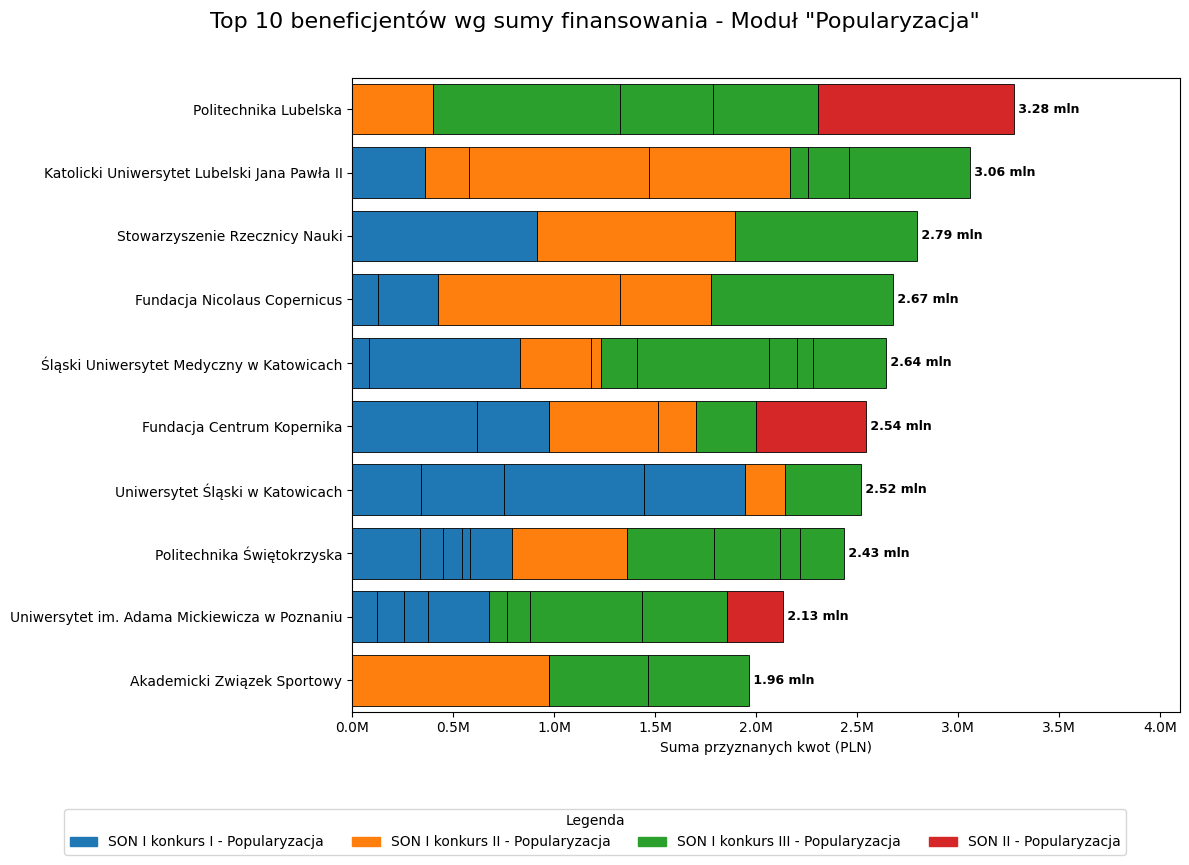

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy as np

konkurs_colors = {
    'SON I konkurs I': '#1f77b4',
    'SON I konkurs II': '#ff7f0e',
    'SON I konkurs III': '#2ca02c',
    'SON II': '#d62728',
}
modul_shades = {
    'Popularyzacja': 1.0,
    'Biblioteki': 0.6,
}
def adjust_hex_brightness(hex_color, factor):
    if factor == 1.0: return hex_color
    rgb = [int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)]
    adjusted_rgb = [min(255, int(c * factor + (255 * (1-factor)))) for c in rgb]
    return f"#{''.join([f'{c:02x}' for c in adjusted_rgb])}"

def create_detailed_stacked_barh_chart(ax, long_df, value_col, title_text, xlabel_text, is_amount):
    beneficjenci = long_df['Wnioskodawca'].cat.categories
    left_positions = {b: 0 for b in beneficjenci}
    for index, row in long_df.iterrows():
        beneficjent, konkurs, modul, value = row['Wnioskodawca'], row['Konkurs'], row['Moduł'], row[value_col]
        base_color = konkurs_colors.get(konkurs, '#888888')
        shade_factor = modul_shades.get(modul, 1.0)
        color = adjust_hex_brightness(base_color, shade_factor)
        left = left_positions[beneficjent]
        ax.barh(beneficjent, value, left=left, color=color, edgecolor='black', linewidth=0.6, align='center')
        left_positions[beneficjent] += value
    ax.set_title(title_text, fontsize=14, pad=15)
    ax.set_xlabel(xlabel_text)
    ax.invert_yaxis()
    ax.margins(y=0.01)
    totals = long_df.groupby('Wnioskodawca', observed=True)[value_col].sum()
    if is_amount:
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x/1_000_000:.1f}M'))
        for i, total in enumerate(totals): ax.text(total, i, f' {total/1_000_000:.2f} mln', va='center', ha='left', fontsize=9, weight='bold')
        ax.set_xlim(right=totals.max() * 1.25)
    else:
        for i, total in enumerate(totals): ax.text(total, i, f' {int(total)}', va='center', ha='left', fontsize=9, weight='bold')
        ax.set_xlim(right=totals.max() * 1.25)
        ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))


df_pop = df_all[df_all['Moduł'] == 'Popularyzacja'].copy()

top_amounts_pop = df_pop.groupby("Wnioskodawca")['Kwota_clean'].sum().nlargest(10).reset_index()
top_amounts_pop.columns = ["Wnioskodawca", "Suma kwot"]

df_amounts_long_pop = df_pop[df_pop['Wnioskodawca'].isin(top_amounts_pop['Wnioskodawca'])].copy()
df_amounts_long_pop['Wnioskodawca'] = pd.Categorical(df_amounts_long_pop['Wnioskodawca'], categories=top_amounts_pop['Wnioskodawca'], ordered=True)
df_amounts_long_pop = df_amounts_long_pop.sort_values(by=['Wnioskodawca', 'Konkurs', 'Moduł'])

fig_pop, ax_pop = plt.subplots(1, 1, figsize=(12, 8))
fig_pop.suptitle('Top 10 beneficjentów wg sumy finansowania - Moduł "Popularyzacja"', fontsize=16, y=1.0)

create_detailed_stacked_barh_chart(ax_pop, df_amounts_long_pop, 'Kwota_clean', "", "Suma przyznanych kwot (PLN)", is_amount=True)

legend_patches_pop = []
all_combinations_pop = set(tuple(row) for row in df_pop[['Konkurs', 'Moduł']].drop_duplicates().to_numpy())
for konkurs in sorted(konkurs_colors.keys()):
    for modul, shade in modul_shades.items():
        if (konkurs, modul) in all_combinations_pop:
             base_color = konkurs_colors.get(konkurs)
             color = adjust_hex_brightness(base_color, shade)
             label = f"{konkurs} - {modul}"
             legend_patches_pop.append(mpatches.Patch(color=color, label=label))

fig_pop.legend(handles=legend_patches_pop, loc='upper center', bbox_to_anchor=(0.5, 0.01), ncol=4, title="Legenda")
plt.tight_layout(rect=[0, 0.05, 1, 0.98])
plt.show()

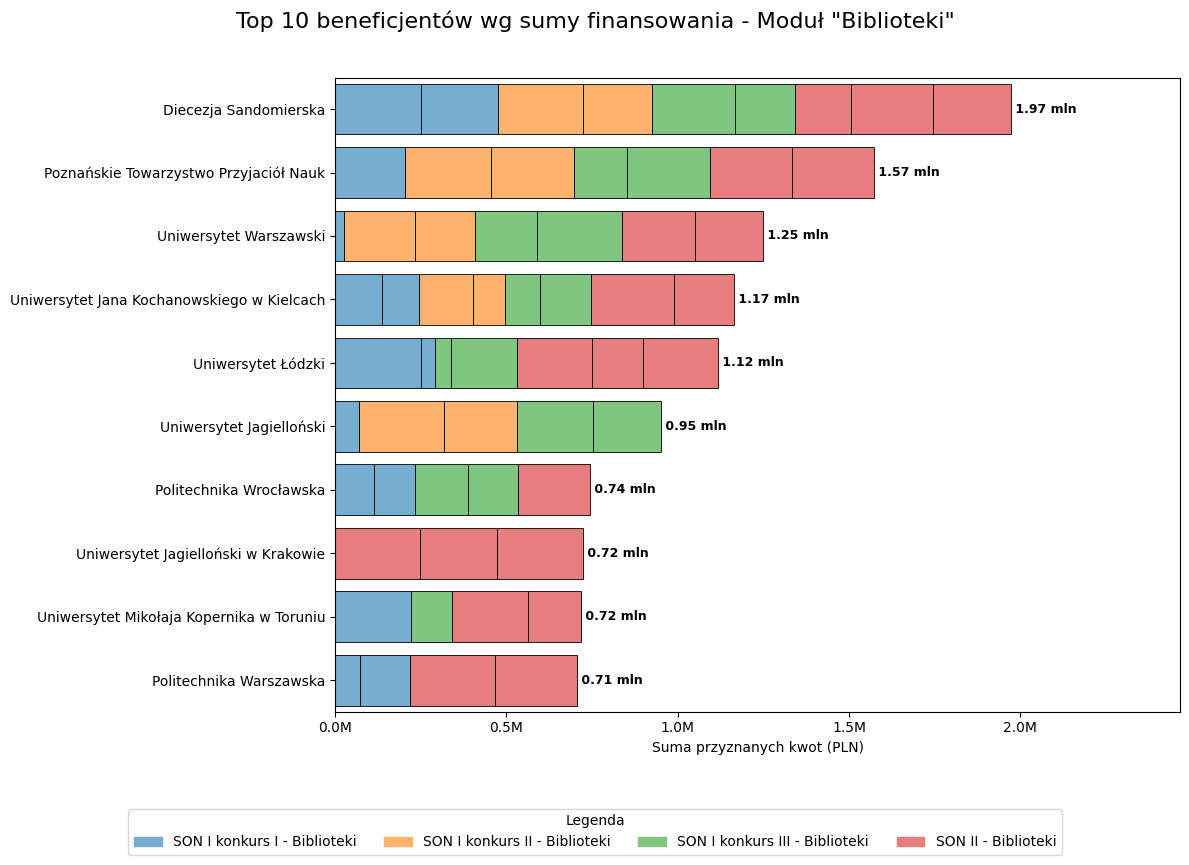

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy as np

konkurs_colors = {
    'SON I konkurs I': '#1f77b4',
    'SON I konkurs II': '#ff7f0e',
    'SON I konkurs III': '#2ca02c',
    'SON II': '#d62728',
}
modul_shades = {
    'Popularyzacja': 1.0,
    'Biblioteki': 0.6,
}
def adjust_hex_brightness(hex_color, factor):
    if factor == 1.0: return hex_color
    rgb = [int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)]
    adjusted_rgb = [min(255, int(c * factor + (255 * (1-factor)))) for c in rgb]
    return f"#{''.join([f'{c:02x}' for c in adjusted_rgb])}"

def create_detailed_stacked_barh_chart(ax, long_df, value_col, title_text, xlabel_text, is_amount):
    beneficjenci = long_df['Wnioskodawca'].cat.categories
    left_positions = {b: 0 for b in beneficjenci}
    for index, row in long_df.iterrows():
        beneficjent, konkurs, modul, value = row['Wnioskodawca'], row['Konkurs'], row['Moduł'], row[value_col]
        base_color = konkurs_colors.get(konkurs, '#888888')
        shade_factor = modul_shades.get(modul, 1.0)
        color = adjust_hex_brightness(base_color, shade_factor)
        left = left_positions[beneficjent]
        ax.barh(beneficjent, value, left=left, color=color, edgecolor='black', linewidth=0.6, align='center')
        left_positions[beneficjent] += value
    ax.set_title(title_text, fontsize=14, pad=15)
    ax.set_xlabel(xlabel_text)
    ax.invert_yaxis()
    ax.margins(y=0.01)
    totals = long_df.groupby('Wnioskodawca', observed=True)[value_col].sum()
    if is_amount:
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x/1_000_000:.1f}M'))
        for i, total in enumerate(totals): ax.text(total, i, f' {total/1_000_000:.2f} mln', va='center', ha='left', fontsize=9, weight='bold')
        ax.set_xlim(right=totals.max() * 1.25)
    else:
        for i, total in enumerate(totals): ax.text(total, i, f' {int(total)}', va='center', ha='left', fontsize=9, weight='bold')
        ax.set_xlim(right=totals.max() * 1.25)
        ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))


df_bibl = df_all[df_all['Moduł'] == 'Biblioteki'].copy()

if df_bibl.empty:
    print("Brak danych dla modułu 'Biblioteki' do wyświetlenia.")
else:
    top_amounts_bibl = df_bibl.groupby("Wnioskodawca")['Kwota_clean'].sum().nlargest(10).reset_index()
    top_amounts_bibl.columns = ["Wnioskodawca", "Suma kwot"]

    df_amounts_long_bibl = df_bibl[df_bibl['Wnioskodawca'].isin(top_amounts_bibl['Wnioskodawca'])].copy()
    df_amounts_long_bibl['Wnioskodawca'] = pd.Categorical(df_amounts_long_bibl['Wnioskodawca'], categories=top_amounts_bibl['Wnioskodawca'], ordered=True)
    df_amounts_long_bibl = df_amounts_long_bibl.sort_values(by=['Wnioskodawca', 'Konkurs', 'Moduł'])

    fig_bibl, ax_bibl = plt.subplots(1, 1, figsize=(12, 8))
    fig_bibl.suptitle('Top 10 beneficjentów wg sumy finansowania - Moduł "Biblioteki"', fontsize=16, y=1.0)

    create_detailed_stacked_barh_chart(ax_bibl, df_amounts_long_bibl, 'Kwota_clean', "", "Suma przyznanych kwot (PLN)", is_amount=True)

    legend_patches_bibl = []
    all_combinations_bibl = set(tuple(row) for row in df_bibl[['Konkurs', 'Moduł']].drop_duplicates().to_numpy())
    for konkurs in sorted(konkurs_colors.keys()):
        for modul, shade in modul_shades.items():
            if (konkurs, modul) in all_combinations_bibl:
                 base_color = konkurs_colors.get(konkurs)
                 color = adjust_hex_brightness(base_color, shade)
                 label = f"{konkurs} - {modul}"
                 legend_patches_bibl.append(mpatches.Patch(color=color, label=label))

    fig_bibl.legend(handles=legend_patches_bibl, loc='upper center', bbox_to_anchor=(0.5, 0.01), ncol=4, title="Legenda")
    plt.tight_layout(rect=[0, 0.05, 1, 0.98])
    plt.show()

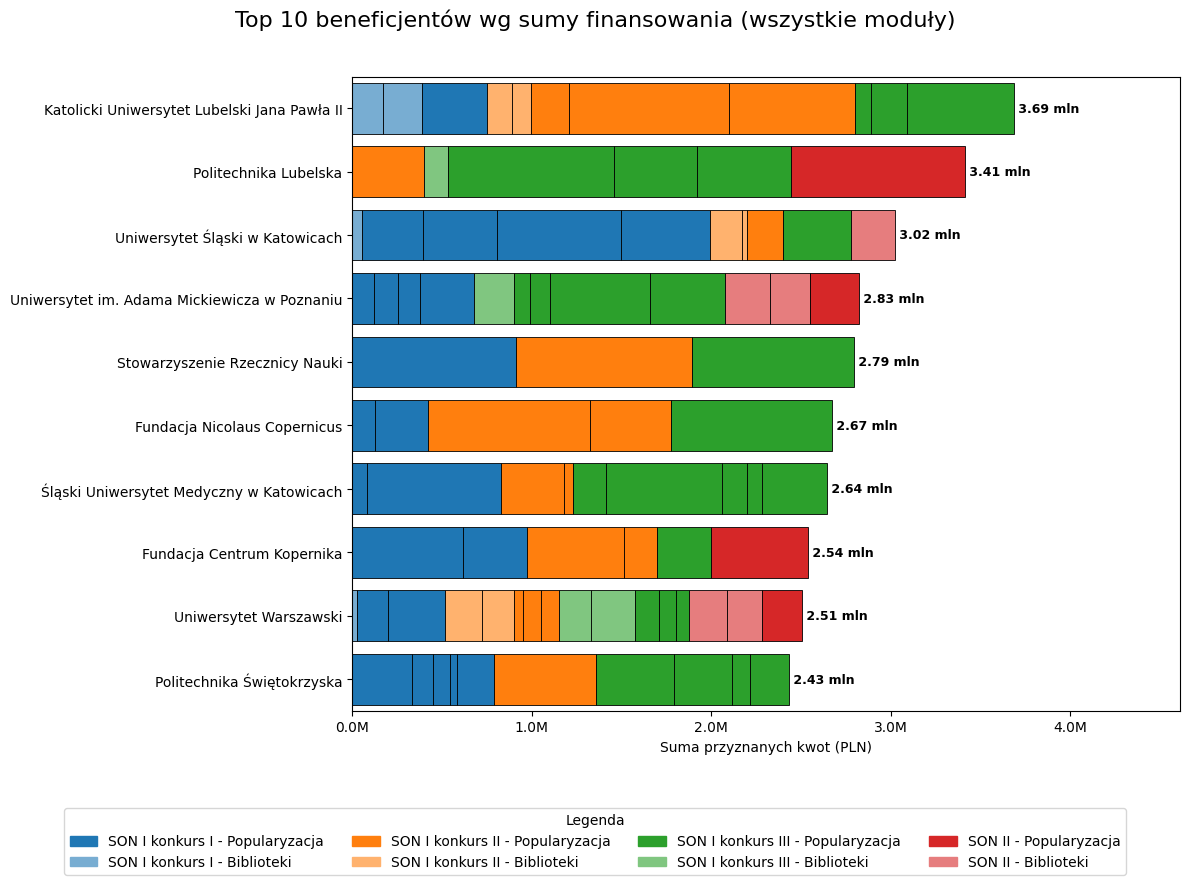

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy as np

konkurs_colors = {
    'SON I konkurs I': '#1f77b4',
    'SON I konkurs II': '#ff7f0e',
    'SON I konkurs III': '#2ca02c',
    'SON II': '#d62728',
}
modul_shades = {
    'Popularyzacja': 1.0,
    'Biblioteki': 0.6,
}
def adjust_hex_brightness(hex_color, factor):
    if factor == 1.0: return hex_color
    rgb = [int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)]
    adjusted_rgb = [min(255, int(c * factor + (255 * (1-factor)))) for c in rgb]
    return f"#{''.join([f'{c:02x}' for c in adjusted_rgb])}"

def create_detailed_stacked_barh_chart(ax, long_df, value_col, title_text, xlabel_text, is_amount):
    beneficjenci = long_df['Wnioskodawca'].cat.categories
    left_positions = {b: 0 for b in beneficjenci}
    for index, row in long_df.iterrows():
        beneficjent, konkurs, modul, value = row['Wnioskodawca'], row['Konkurs'], row['Moduł'], row[value_col]
        base_color = konkurs_colors.get(konkurs, '#888888')
        shade_factor = modul_shades.get(modul, 1.0)
        color = adjust_hex_brightness(base_color, shade_factor)
        left = left_positions[beneficjent]
        ax.barh(beneficjent, value, left=left, color=color, edgecolor='black', linewidth=0.6, align='center')
        left_positions[beneficjent] += value
    ax.set_title(title_text, fontsize=14, pad=15)
    ax.set_xlabel(xlabel_text)
    ax.invert_yaxis()
    ax.margins(y=0.01)
    totals = long_df.groupby('Wnioskodawca', observed=True)[value_col].sum()
    if is_amount:
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x/1_000_000:.1f}M'))
        for i, total in enumerate(totals): ax.text(total, i, f' {total/1_000_000:.2f} mln', va='center', ha='left', fontsize=9, weight='bold')
        ax.set_xlim(right=totals.max() * 1.25)
    else:
        for i, total in enumerate(totals): ax.text(total, i, f' {int(total)}', va='center', ha='left', fontsize=9, weight='bold')
        ax.set_xlim(right=totals.max() * 1.25)
        ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))


top_amounts_all = df_all.groupby("Wnioskodawca")['Kwota_clean'].sum().nlargest(10).reset_index()
top_amounts_all.columns = ["Wnioskodawca", "Suma kwot"]

df_amounts_long_all = df_all[df_all['Wnioskodawca'].isin(top_amounts_all['Wnioskodawca'])].copy()
df_amounts_long_all['Wnioskodawca'] = pd.Categorical(df_amounts_long_all['Wnioskodawca'], categories=top_amounts_all['Wnioskodawca'], ordered=True)
df_amounts_long_all = df_amounts_long_all.sort_values(by=['Wnioskodawca', 'Konkurs', 'Moduł'])

fig_all, ax_all = plt.subplots(1, 1, figsize=(12, 8))
fig_all.suptitle('Top 10 beneficjentów wg sumy finansowania (wszystkie moduły)', fontsize=16, y=1.0)

create_detailed_stacked_barh_chart(ax_all, df_amounts_long_all, 'Kwota_clean', "", "Suma przyznanych kwot (PLN)", is_amount=True)

legend_patches_all = []
all_combinations = set(tuple(row) for row in df_all[['Konkurs', 'Moduł']].drop_duplicates().to_numpy())
for konkurs in sorted(konkurs_colors.keys()):
    for modul, shade in modul_shades.items():
        if (konkurs, modul) in all_combinations:
             base_color = konkurs_colors.get(konkurs)
             color = adjust_hex_brightness(base_color, shade)
             label = f"{konkurs} - {modul}"
             legend_patches_all.append(mpatches.Patch(color=color, label=label))

fig_all.legend(handles=legend_patches_all, loc='upper center', bbox_to_anchor=(0.5, 0.01), ncol=4, title="Legenda")
plt.tight_layout(rect=[0, 0.05, 1, 0.98])
plt.show()

Podział beneficjentów na kategorie:
Kategoria
Uczelnie     593
NGOs         163
Pozostałe     74
Name: count, dtype: int64
------------------------------

Generowanie wykresu dla kategorii: Uczelnie...


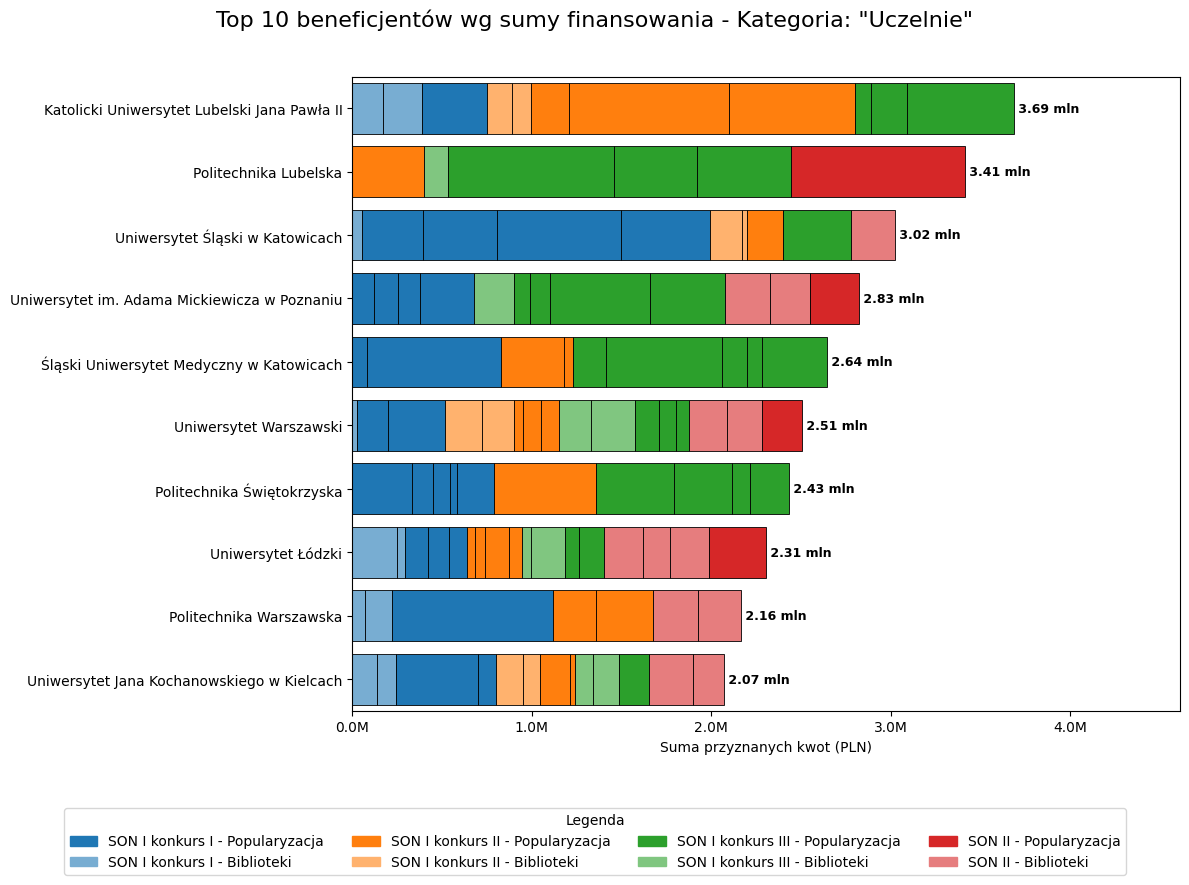


Generowanie wykresu dla kategorii: NGOs...


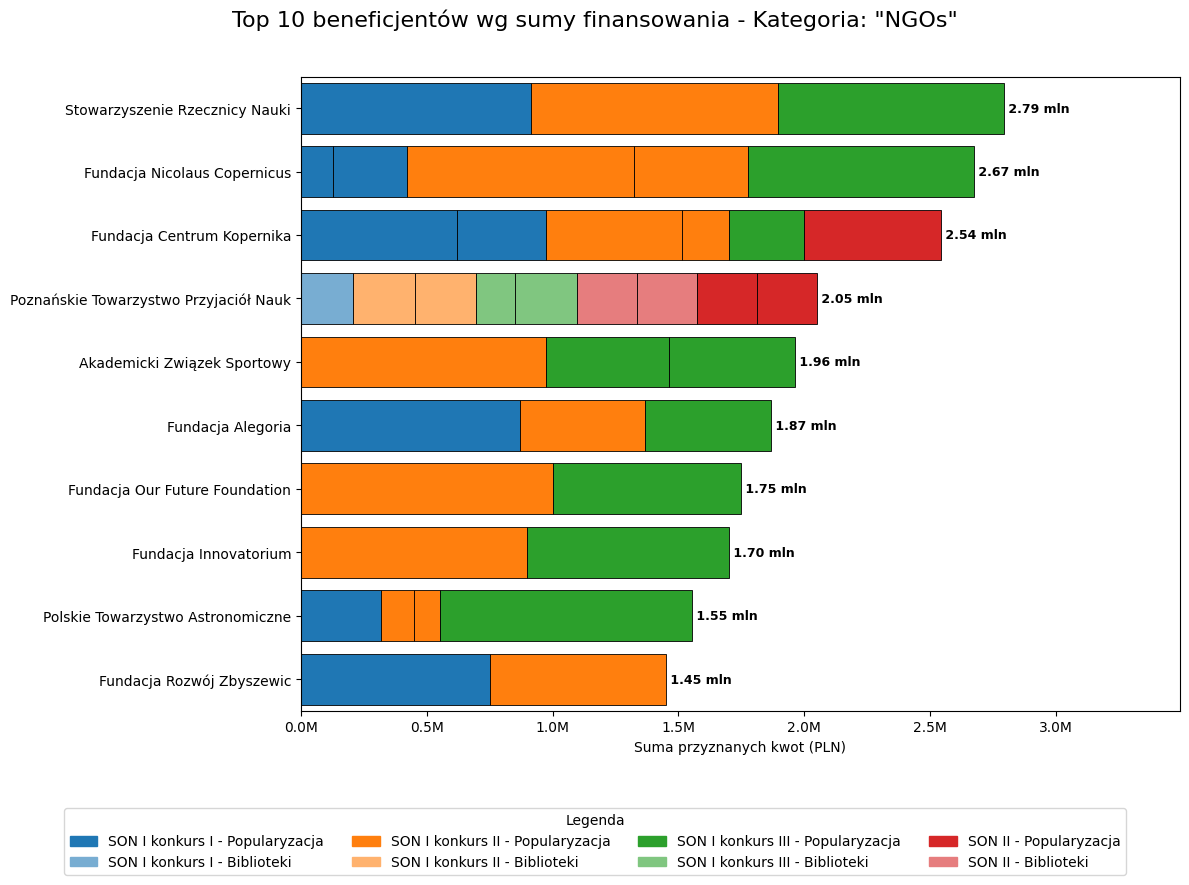


Generowanie wykresu dla kategorii: Pozostałe...


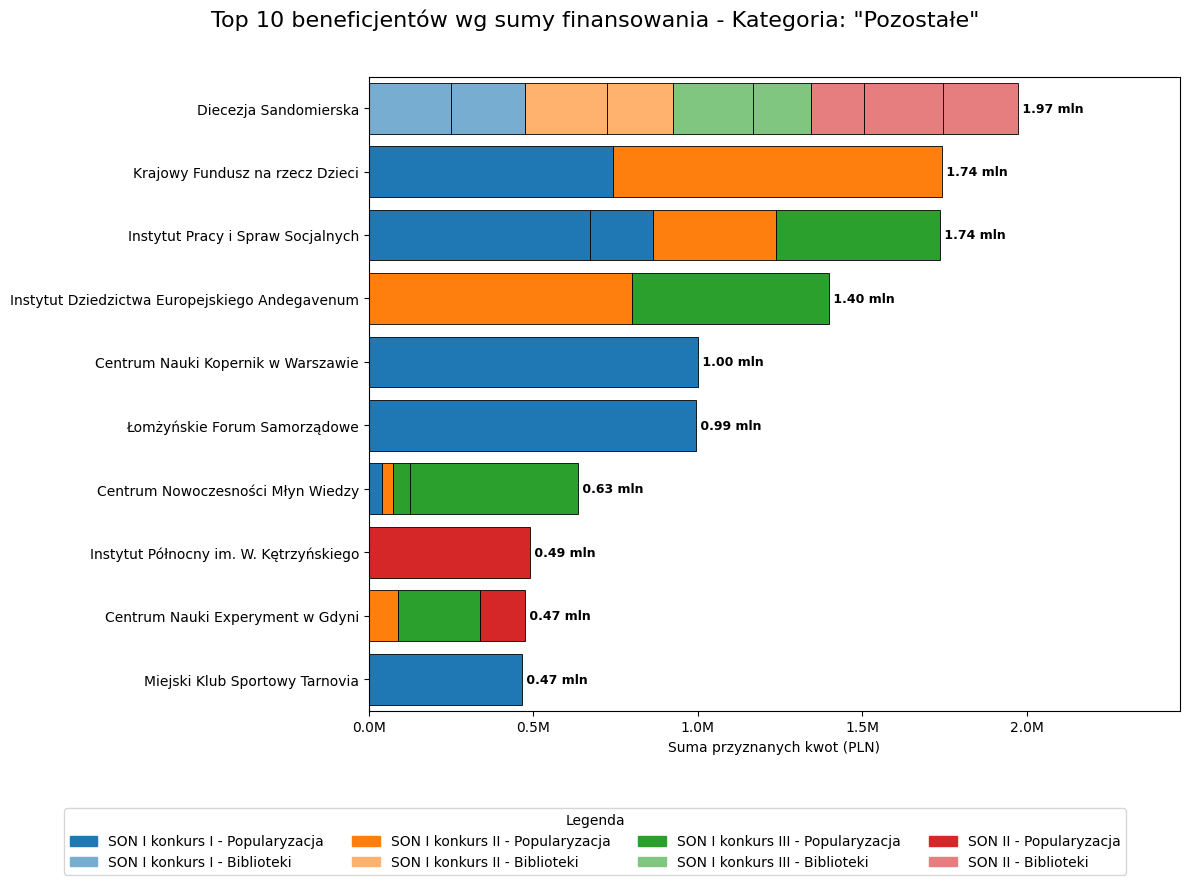

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy as np

konkurs_colors = {
    'SON I konkurs I': '#1f77b4',
    'SON I konkurs II': '#ff7f0e',
    'SON I konkurs III': '#2ca02c',
    'SON II': '#d62728',
}
modul_shades = {
    'Popularyzacja': 1.0,
    'Biblioteki': 0.6,
}
def adjust_hex_brightness(hex_color, factor):
    if factor == 1.0: return hex_color
    rgb = [int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)]
    adjusted_rgb = [min(255, int(c * factor + (255 * (1-factor)))) for c in rgb]
    return f"#{''.join([f'{c:02x}' for c in adjusted_rgb])}"

def create_detailed_stacked_barh_chart(ax, long_df, value_col, title_text, xlabel_text, is_amount):
    if long_df.empty:
        ax.text(0.5, 0.5, 'Brak danych do wyświetlenia', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title(title_text, fontsize=14, pad=15)
        return
        
    beneficjenci = long_df['Wnioskodawca'].cat.categories
    left_positions = {b: 0 for b in beneficjenci}
    for index, row in long_df.iterrows():
        beneficjent, konkurs, modul, value = row['Wnioskodawca'], row['Konkurs'], row['Moduł'], row[value_col]
        base_color = konkurs_colors.get(konkurs, '#888888')
        shade_factor = modul_shades.get(modul, 1.0)
        color = adjust_hex_brightness(base_color, shade_factor)
        left = left_positions[beneficjent]
        ax.barh(beneficjent, value, left=left, color=color, edgecolor='black', linewidth=0.6, align='center')
        left_positions[beneficjent] += value
    ax.set_title(title_text, fontsize=14, pad=15)
    ax.set_xlabel(xlabel_text)
    ax.invert_yaxis()
    ax.margins(y=0.01)
    totals = long_df.groupby('Wnioskodawca', observed=True)[value_col].sum()
    if is_amount:
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x/1_000_000:.1f}M'))
        for i, total in enumerate(totals): ax.text(total, i, f' {total/1_000_000:.2f} mln', va='center', ha='left', fontsize=9, weight='bold')
        ax.set_xlim(right=totals.max() * 1.25)
    else:
        for i, total in enumerate(totals): ax.text(total, i, f' {int(total)}', va='center', ha='left', fontsize=9, weight='bold')
        ax.set_xlim(right=totals.max() * 1.25)
        ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))


cond_uczelnie = df_all['Wnioskodawca'].str.contains(
    'uniwersytet|akademia|politechnika|szkoła wyższa|wyższa szkoła|polskiej akademii nauk|szkoła główna|uczelnia', 
    case=False, 
    na=False
)
cond_ngos = df_all['Wnioskodawca'].str.contains(
    'fundacja|stowarzyszenie|towarzystwo|związek', 
    case=False, 
    na=False
)

conditions = [cond_uczelnie, cond_ngos]
choices = ['Uczelnie', 'NGOs']

df_all['Kategoria'] = np.select(conditions, choices, default='Pozostałe')

print("Podział beneficjentów na kategorie:")
print(df_all['Kategoria'].value_counts())
print("-" * 30)


kategorie = ['Uczelnie', 'NGOs', 'Pozostałe']

for kategoria in kategorie:
    print(f"\nGenerowanie wykresu dla kategorii: {kategoria}...")
    
    df_kat = df_all[df_all['Kategoria'] == kategoria].copy()

    if df_kat.empty:
        print(f"Brak danych dla kategorii '{kategoria}'. Pomijam.")
        continue

    top_amounts_kat = df_kat.groupby("Wnioskodawca")['Kwota_clean'].sum().nlargest(10).reset_index()
    top_amounts_kat.columns = ["Wnioskodawca", "Suma kwot"]

    if top_amounts_kat.empty:
        print(f"Brak danych do wygenerowania rankingu Top 10 dla '{kategoria}'. Pomijam.")
        continue

    df_long_kat = df_kat[df_kat['Wnioskodawca'].isin(top_amounts_kat['Wnioskodawca'])].copy()
    df_long_kat['Wnioskodawca'] = pd.Categorical(df_long_kat['Wnioskodawca'], categories=top_amounts_kat['Wnioskodawca'], ordered=True)
    df_long_kat = df_long_kat.sort_values(by=['Wnioskodawca', 'Konkurs', 'Moduł'])

    fig_kat, ax_kat = plt.subplots(1, 1, figsize=(12, 8))
    fig_kat.suptitle(f'Top 10 beneficjentów wg sumy finansowania - Kategoria: "{kategoria}"', fontsize=16, y=1.0)
    
    create_detailed_stacked_barh_chart(ax_kat, df_long_kat, 'Kwota_clean', "", "Suma przyznanych kwot (PLN)", is_amount=True)

    legend_patches_kat = []
    all_combinations_kat = set(tuple(row) for row in df_kat[['Konkurs', 'Moduł']].drop_duplicates().to_numpy())
    for konkurs in sorted(konkurs_colors.keys()):
        for modul, shade in modul_shades.items():
            if (konkurs, modul) in all_combinations_kat:
                 base_color = konkurs_colors.get(konkurs)
                 color = adjust_hex_brightness(base_color, shade)
                 label = f"{konkurs} - {modul}"
                 legend_patches_kat.append(mpatches.Patch(color=color, label=label))

    fig_kat.legend(handles=legend_patches_kat, loc='upper center', bbox_to_anchor=(0.5, 0.01), ncol=4, title="Legenda")
    plt.tight_layout(rect=[0, 0.05, 1, 0.98])
    plt.show()

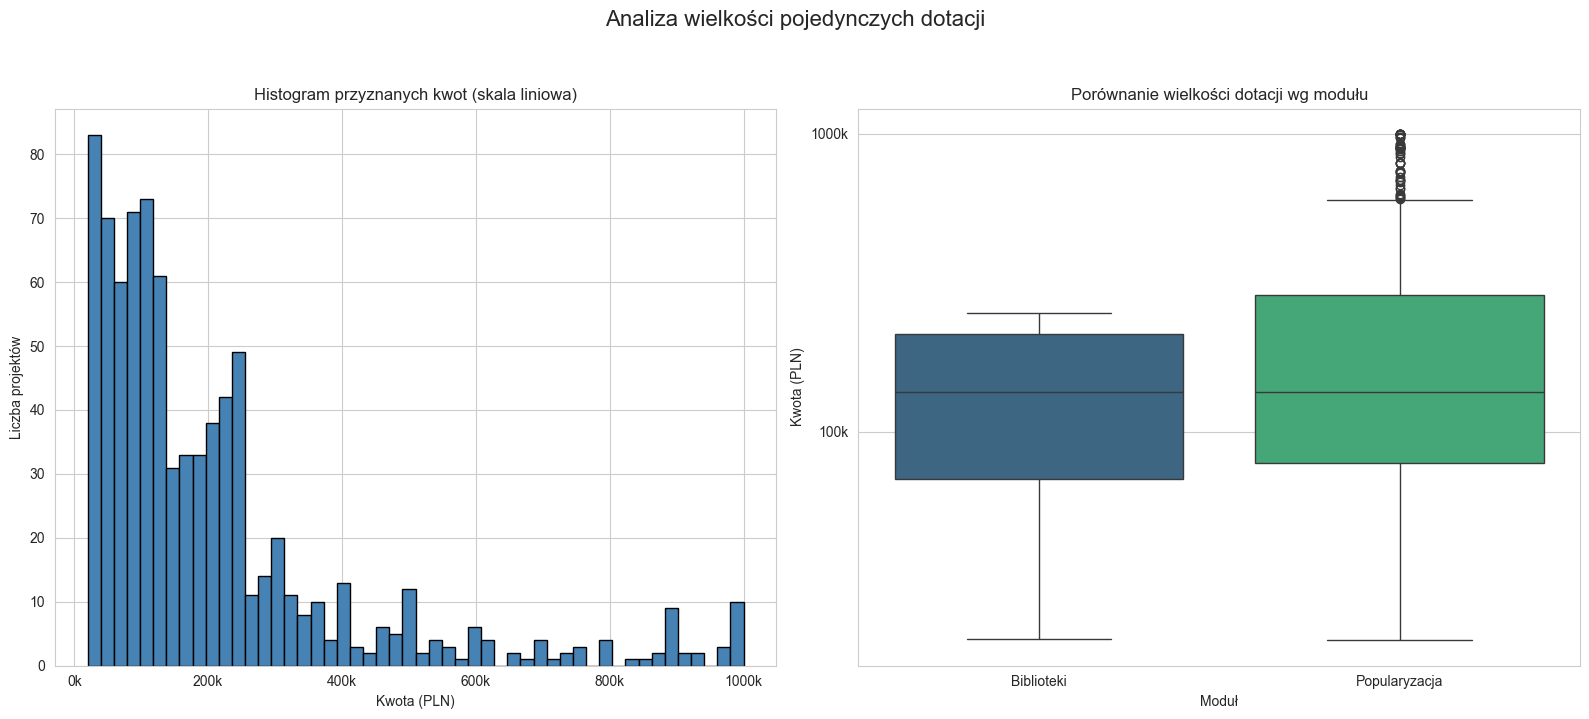

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Analiza wielkości pojedynczych dotacji', fontsize=16, y=1.02)

positive_amounts = df_all[df_all['Kwota_clean'] > 0]['Kwota_clean']
ax1.hist(positive_amounts, bins=50, color='steelblue', edgecolor='black')
ax1.set_title('Histogram przyznanych kwot (skala liniowa)')
ax1.set_xlabel('Kwota (PLN)')
ax1.set_ylabel('Liczba projektów')
ax1.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x/1000:.0f}k'))


sns.boxplot(ax=ax2, x='Moduł', y='Kwota_clean', data=df_all, palette='viridis')
ax2.set_title('Porównanie wielkości dotacji wg modułu')
ax2.set_xlabel('Moduł')
ax2.set_ylabel('Kwota (PLN)')
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, p: f'{y/1000:.0f}k' if y >= 1000 else f'{y}'))


plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

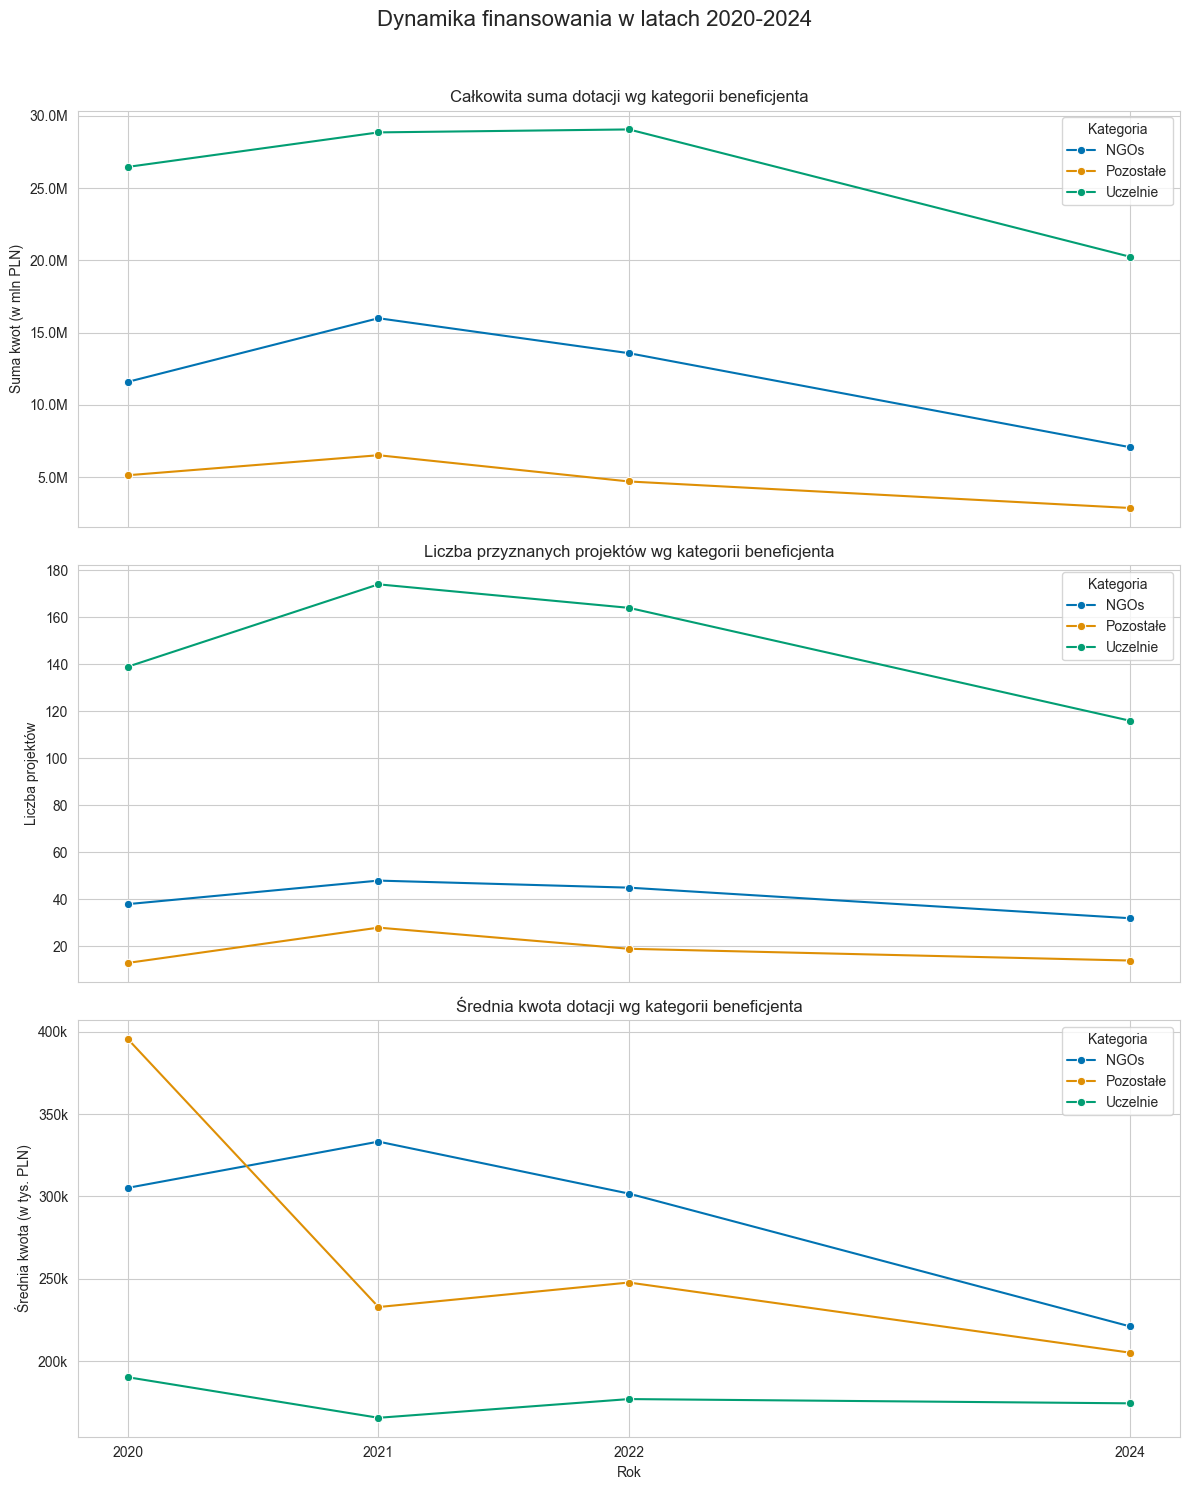

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

if 'Kategoria' not in df_all.columns:
    raise ValueError("Najpierw uruchom kod kategoryzujący beneficjentów.")

df_yearly = df_all.groupby(['Rok', 'Kategoria'])['Kwota_clean'].agg(['sum', 'count', 'mean']).reset_index()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
fig.suptitle('Dynamika finansowania w latach 2020-2024', fontsize=16, y=0.99)

sns.lineplot(ax=ax1, data=df_yearly, x='Rok', y='sum', hue='Kategoria', marker='o', palette='colorblind')
ax1.set_title('Całkowita suma dotacji wg kategorii beneficjenta')
ax1.set_ylabel('Suma kwot (w mln PLN)')
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, p: f'{y/1_000_000:.1f}M'))

sns.lineplot(ax=ax2, data=df_yearly, x='Rok', y='count', hue='Kategoria', marker='o', palette='colorblind')
ax2.set_title('Liczba przyznanych projektów wg kategorii beneficjenta')
ax2.set_ylabel('Liczba projektów')

sns.lineplot(ax=ax3, data=df_yearly, x='Rok', y='mean', hue='Kategoria', marker='o', palette='colorblind')
ax3.set_title('Średnia kwota dotacji wg kategorii beneficjenta')
ax3.set_ylabel('Średnia kwota (w tys. PLN)')
ax3.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, p: f'{y/1000:.0f}k'))

plt.xlabel('Rok')
plt.xticks(df_yearly['Rok'].unique())
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()